<a href="https://colab.research.google.com/github/ManuelBagasina/DATCapstone/blob/Jhee/RF%26LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PreProcessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile


In [2]:
!git clone -b main https://github.com/ManuelBagasina/DATCapstone.git
%cd DATCapstone/data

Cloning into 'DATCapstone'...
remote: Enumerating objects: 752, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 752 (delta 67), reused 27 (delta 27), pack-reused 649 (from 4)
Receiving objects: 100% (752/752), 77.77 MiB | 7.73 MiB/s, done.
Resolving deltas: 100% (393/393), done.
Updating files: 100% (24/24), done.
/content/DATCapstone/data


In [3]:
from zipfile import ZipFile
import pandas as pd

# Explicitly extract data.csv from ZIP
with ZipFile('_data.csv.zip', 'r') as z:
    with z.open('data.csv') as f:  # Ignore macOS metadata files
        df = pd.read_csv(f, index_col=0)

# Convert date and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Ticker', 'Date'])


In [4]:
df

Date        Open        High         Low       Close    Volume  \
149  2021-09-30  140.983670  141.690258  138.648004  138.863907  89056700   
152  2021-10-01  139.256450  140.257452  136.518433  139.992477  94639600   
155  2021-10-04  139.119037  139.560665  135.694064  136.547852  98322000   
158  2021-10-05  136.891371  139.590139  136.763788  138.481186  80861100   
161  2021-10-06  136.871718  139.501783  135.792205  139.354584  83221100   
...         ...         ...         ...         ...         ...       ...   
8062 2025-01-27  394.799988  406.690002  389.000000  397.149994  58125500   
8072 2025-01-28  396.910004  400.589996  386.500000  398.089996  48910700   
8082 2025-01-29  395.209991  398.589996  384.480011  389.100006  68033600   
8092 2025-01-30  410.779999  412.500000  384.410004  400.279999  98092900   
8102 2025-01-31  401.529999  419.989990  401.339996  404.600006  83568200   

      Dividends  Stock Splits  GDP (Billions USD)  Unemployment Rate (%)  ...  \
149         0.0           0.0           23921.991                    4.7  ...   
152         0.0           0.0           24777.038                    4.5  ...   
155         0.0           0.0           24777.038                    4.5  ...   
158         0.0           0.0           24777.038                    4.5  ...   
161         0.0           0.0           24777.038                    4.5  ...   
...         ...           ...                 ...                    ...  ...   
8062        0.0           0.0           29723.864                    4.0  ...   
8072        0.0           0.0           29723.864                    4.0  ...   
8082        0.0           0.0           29723.864                    4.0  ...   
8092        0.0           0.0           29723.864                    4.0  ...   
8102        0.0           0.0           29723.864                    4.0  ...   

       emb_763   emb_764   emb_765   emb_766   emb_767  Target_1day  \
149        NaN       NaN       NaN       NaN       NaN     1.128571   
152        NaN       NaN       NaN       NaN       NaN    -3.444626   
155        NaN       NaN       NaN       NaN       NaN     1.933334   
158        NaN       NaN       NaN       NaN       NaN     0.873398   
161        NaN       NaN       NaN       NaN       NaN     1.265976   
...        ...       ...       ...       ...       ...          ...   
8062  1.174326 -0.262426  0.298183  0.182200  0.388200     0.940002   
8072  0.084330 -0.354550 -0.611864 -0.449780  0.584349    -8.989990   
8082  0.827862 -0.620100 -0.024186 -0.439615  0.781107    11.179993   
8092  1.383147 -0.616897 -0.145329 -0.418483  0.636253     4.320007   
8102  0.658588 -0.312093 -0.158066 -0.211410  0.834208          NaN   

      Target_1week  Target_1month  Target_1year  Ticker  
149       1.756653      10.863785      9.008606    AAPL  
152       0.245331       7.016815      0.616699    AAPL  
155       3.601639       9.637100     -0.162491    AAPL  
158       0.392532       8.744034      2.098389    AAPL  
161      -1.069687       9.313263      4.827057    AAPL  
...            ...            ...           ...     ...  
8062           NaN            NaN           NaN    TSLA  
8072           NaN            NaN           NaN    TSLA  
8082           NaN            NaN           NaN    TSLA  
8092           NaN            NaN           NaN    TSLA  
8102           NaN            NaN           NaN    TSLA  

[8103 rows x 817 columns]

In [7]:
!pip install tensorflow


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Fill missing values in embedding columns
emb_cols = [col for col in df.columns if col.startswith('emb_')]
df[emb_cols] = df[emb_cols].fillna(0)

# Fill all non-target feature columns with 0 (except 'Date', 'Ticker', and targets)
target_cols = [col for col in df.columns if 'Target' in col]
non_target_cols = [col for col in df.columns if col not in target_cols + ['Date', 'Ticker']]
df[non_target_cols] = df[non_target_cols].fillna(0)

# Drop rows that still have NaNs in target columns
df = df.dropna(subset=target_cols)


# Define the function to create sequences
def create_sequences(X, y, look_back=30):
    Xs, ys = [], []
    for i in range(look_back, len(X)):
        Xs.append(X[i - look_back:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)



# Define the function to train LSTM per ticker and target
def run_lstm_by_ticker(df, ticker, target, look_back=30, epochs=20, batch_size=32):
    df_ticker = df[df['Ticker'] == ticker].copy()
    df_ticker = df_ticker.sort_values(by='Date')
    df_ticker = df_ticker.dropna(subset=[target])

    feature_cols = [col for col in df_ticker.columns if 'Target' not in col and col not in ['Date', 'Ticker']]

    df_ticker[feature_cols] = df_ticker[feature_cols].fillna(0)

    X = df_ticker[feature_cols].values
    y = df_ticker[target].values

    # Not enough data
    if len(X) <= look_back + 1:
        print(f"[{ticker}] {target}: Not enough data. Skipping.")
        return

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Scale using only train set
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create sequences
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, look_back)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, look_back)

    if len(X_train_seq) == 0 or len(X_test_seq) == 0:
        print(f"[{ticker}] {target}: Not enough sequence data after processing. Skipping.")
        return

    # Build LSTM model
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        callbacks=[early_stop],
        verbose=0
    )

    # Prediction and evaluation
    y_pred = model.predict(X_test_seq).flatten()
    mae = mean_absolute_error(y_test_seq, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    r2 = r2_score(y_test_seq, y_pred)

    print(f"\n [{ticker}] Target: {target}")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²   : {r2:.4f}")

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_seq, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(f"LSTM Prediction – {ticker} | {target}")
    plt.xlabel('Sample Index')
    plt.ylabel('Target')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [24]:
print("Date dtype:", df['Date'].dtype)
print("Ticker column exists:", 'Ticker' in df.columns)
print("Target columns:", [col for col in df.columns if 'Target' in col])
print("Missing values (top 10):")
print(df.isnull().sum().sort_values(ascending=False).head(10))
print("Column types:")
print(df.dtypes.value_counts())


Date dtype: datetime64[ns]
Ticker column exists: True
Target columns: ['Target_1day', 'Target_1week', 'Target_1month', 'Target_1year']
Missing values (top 10):
Ticker     0
emb_756    0
emb_755    0
emb_754    0
emb_753    0
emb_752    0
emb_751    0
emb_750    0
emb_749    0
emb_748    0
dtype: int64
Column types:
float64           814
datetime64[ns]      1
int64               1
object              1
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step

 [AAPL] Target: Target_1day
MAE : 2.1411
RMSE: 2.8347
R²   : -0.9211


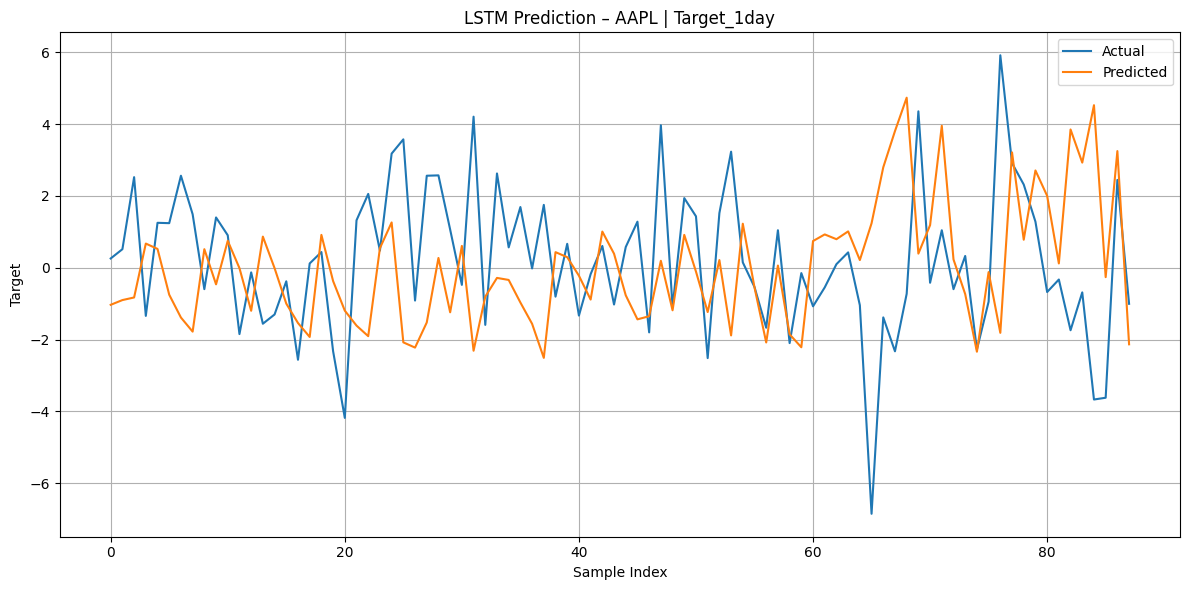

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step

 [AAPL] Target: Target_1week
MAE : 5.5472
RMSE: 6.7295
R²   : -0.5247


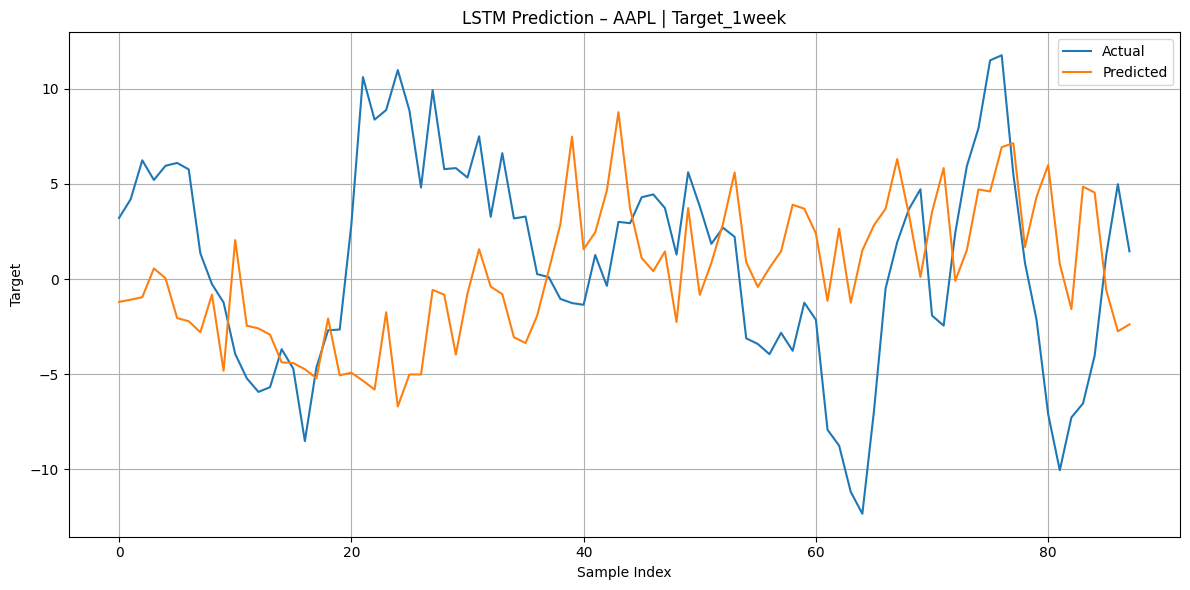

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step

 [AAPL] Target: Target_1month
MAE : 8.6399
RMSE: 11.3055
R²   : -0.4967


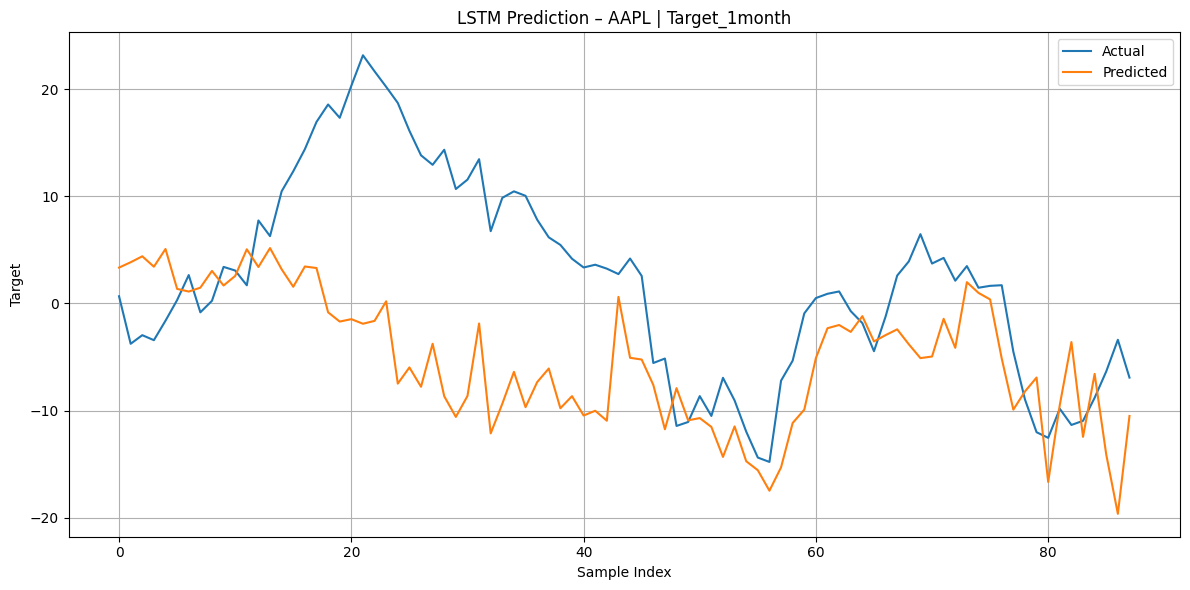

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step

 [AAPL] Target: Target_1year
MAE : 15.7603
RMSE: 19.3232
R²   : -3.1170


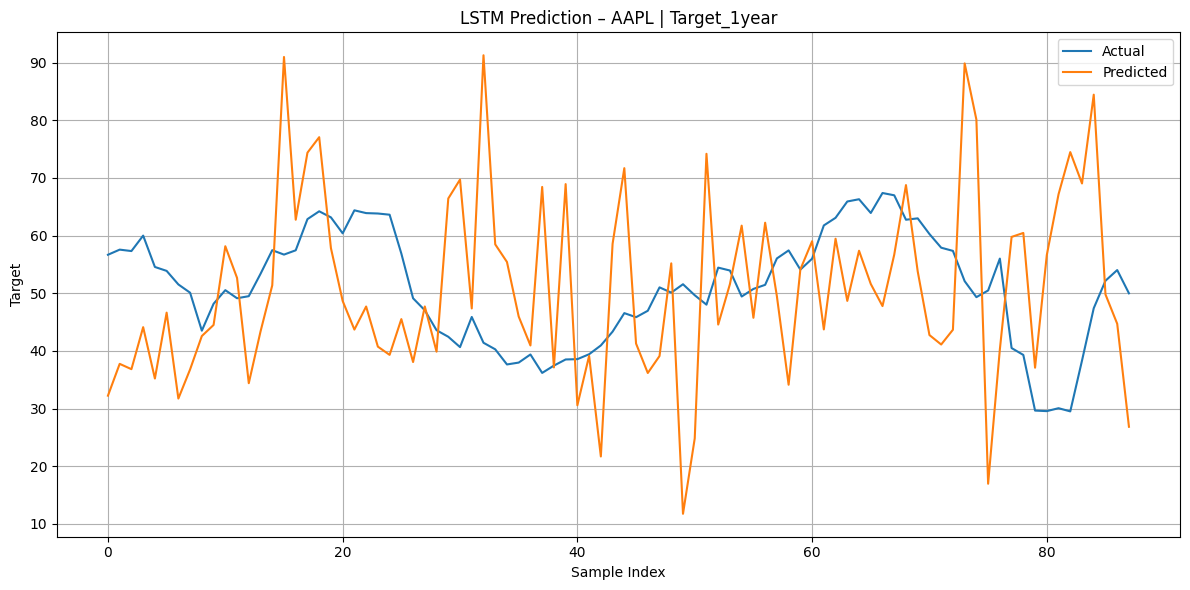

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step

 [AMD] Target: Target_1day
MAE : 2.7972
RMSE: 4.0991
R²   : -0.0820


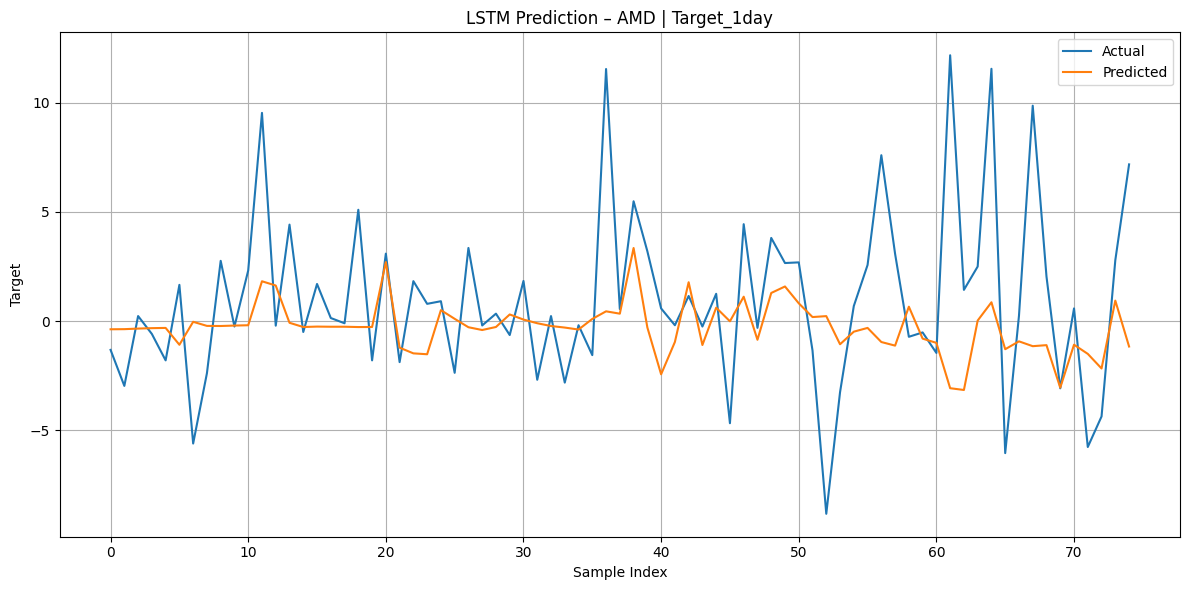

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step

 [AMD] Target: Target_1week
MAE : 8.7404
RMSE: 11.5951
R²   : -0.8942


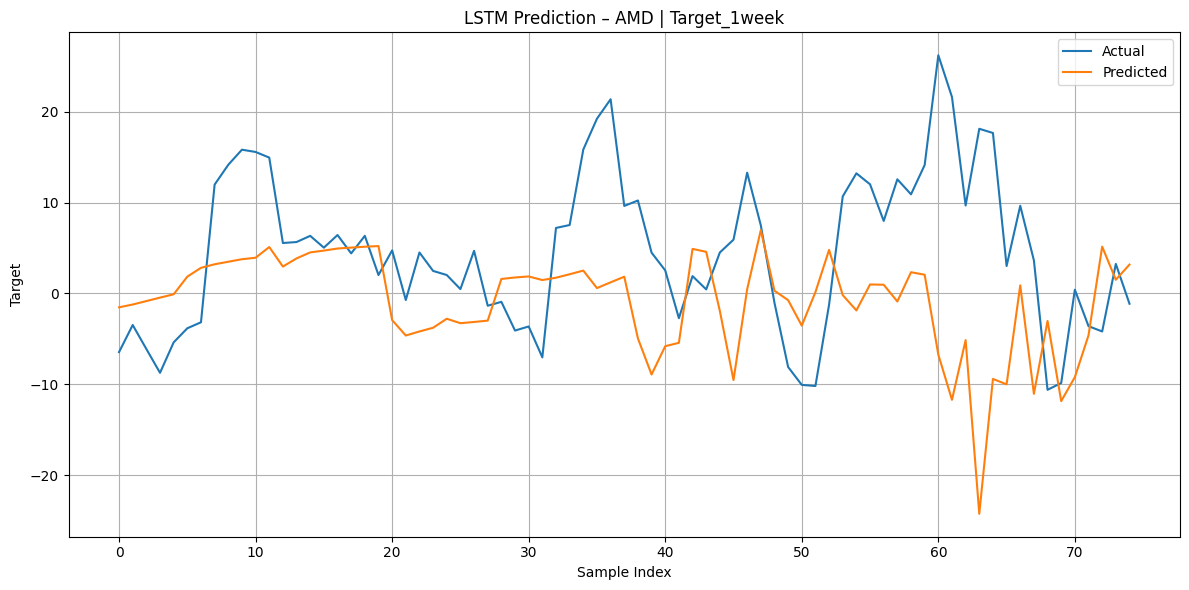

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step

 [AMD] Target: Target_1month
MAE : 19.4608
RMSE: 21.2488
R²   : -3.4713


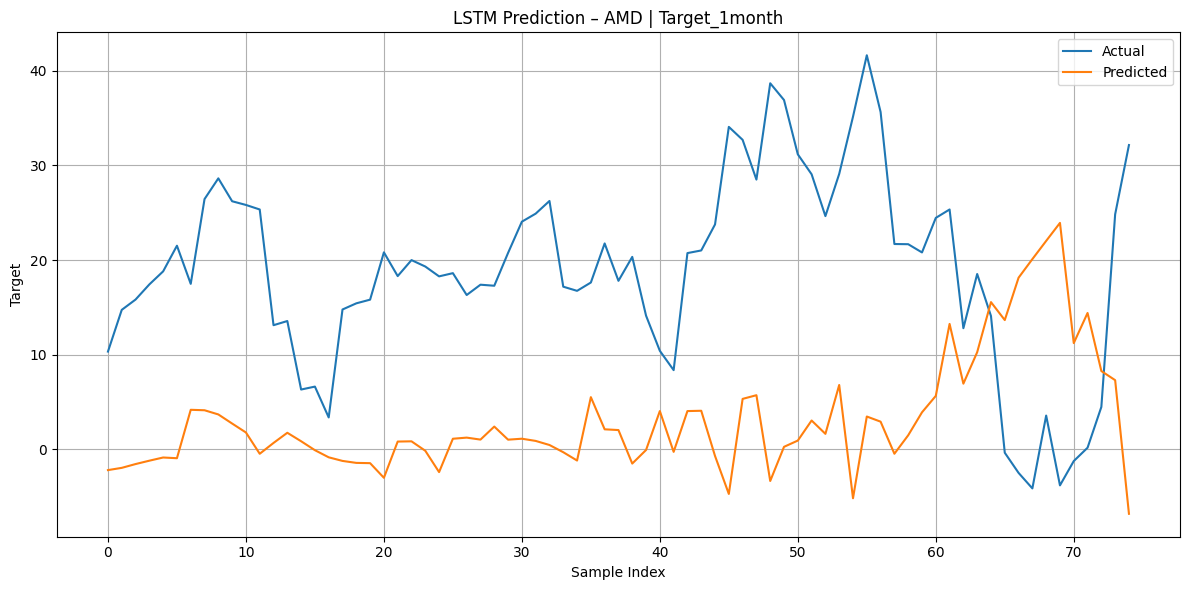

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step

 [AMD] Target: Target_1year
MAE : 35.5890
RMSE: 44.3235
R²   : -0.5084


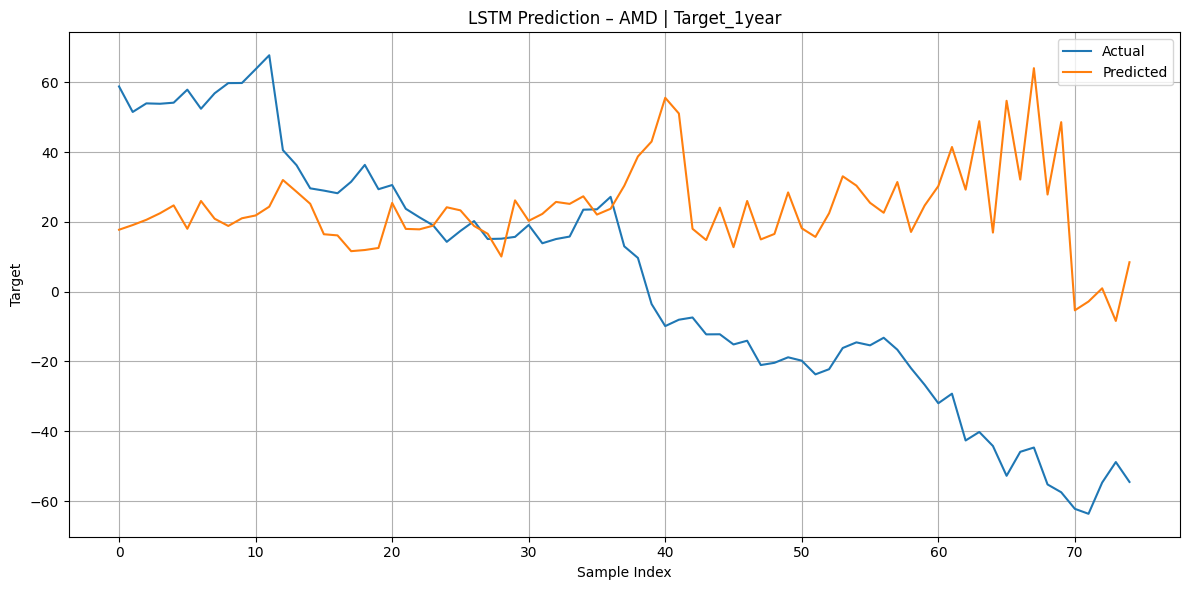

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step

 [AMZN] Target: Target_1day
MAE : 7.0774
RMSE: 12.2870
R²   : -19.3183


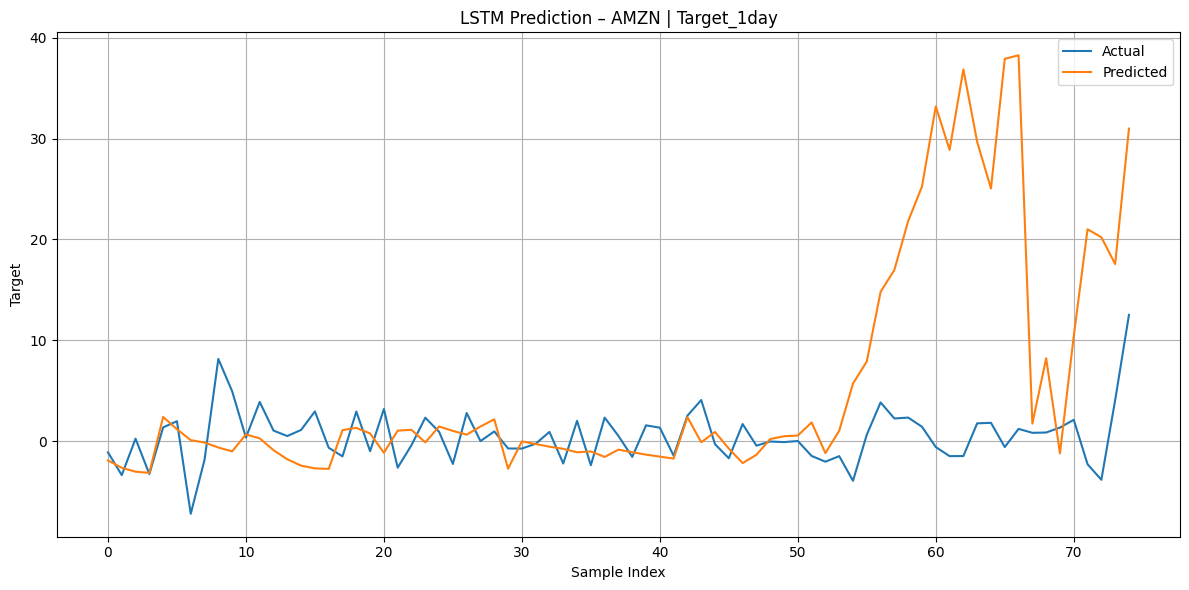

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step

 [AMZN] Target: Target_1week
MAE : 10.1671
RMSE: 15.2906
R²   : -7.2710


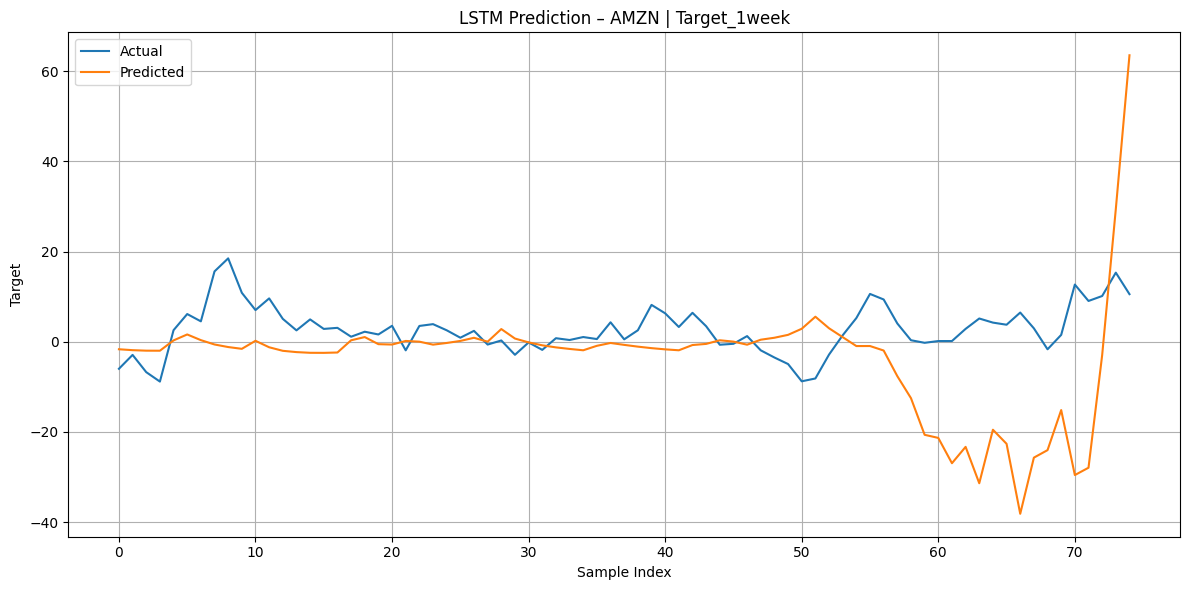

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step

 [AMZN] Target: Target_1month
MAE : 15.6502
RMSE: 22.0144
R²   : -8.7087


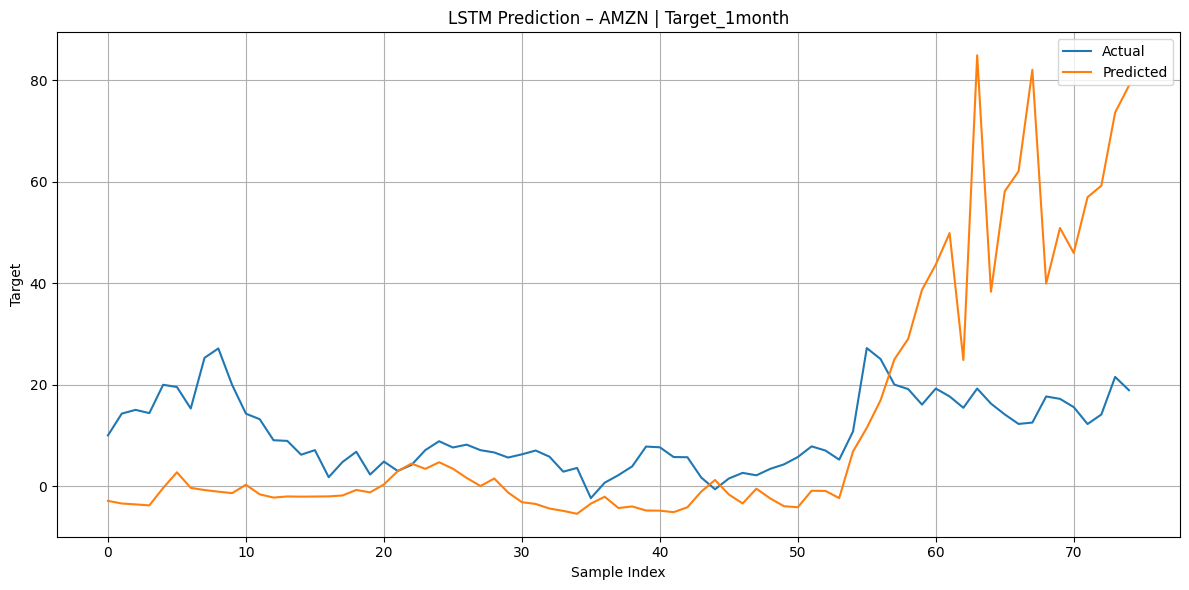

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step

 [AMZN] Target: Target_1year
MAE : 44.9601
RMSE: 47.6044
R²   : -28.5601


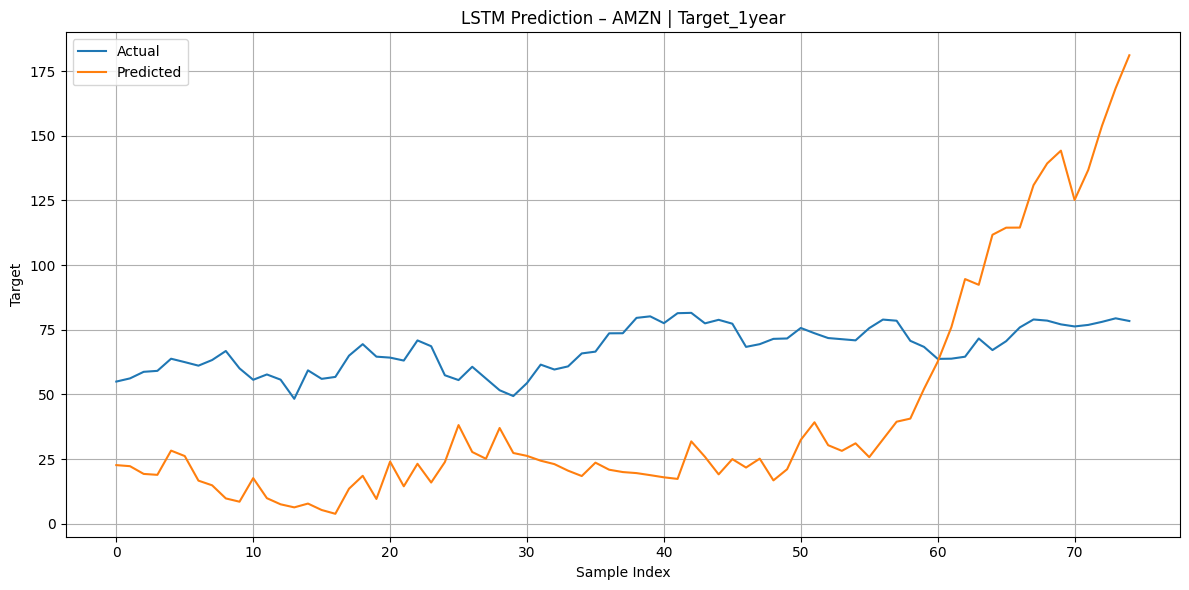

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step

 [AVGO] Target: Target_1day
MAE : 3.5793
RMSE: 5.7613
R²   : -6.9702


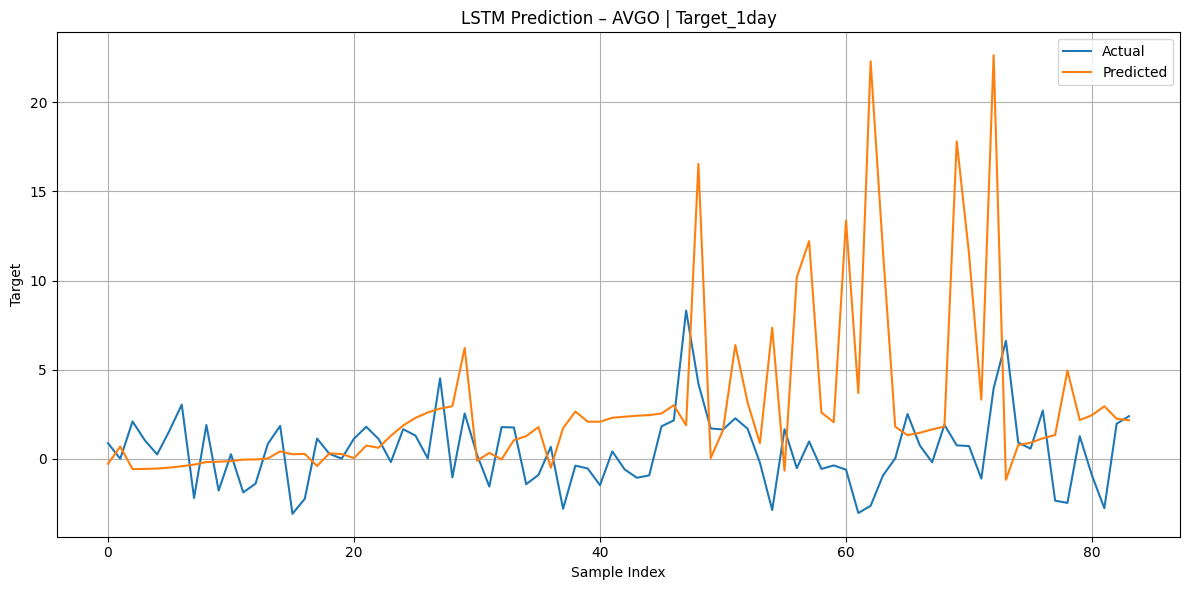

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step

 [AVGO] Target: Target_1week
MAE : 6.4890
RMSE: 8.1309
R²   : -0.8955


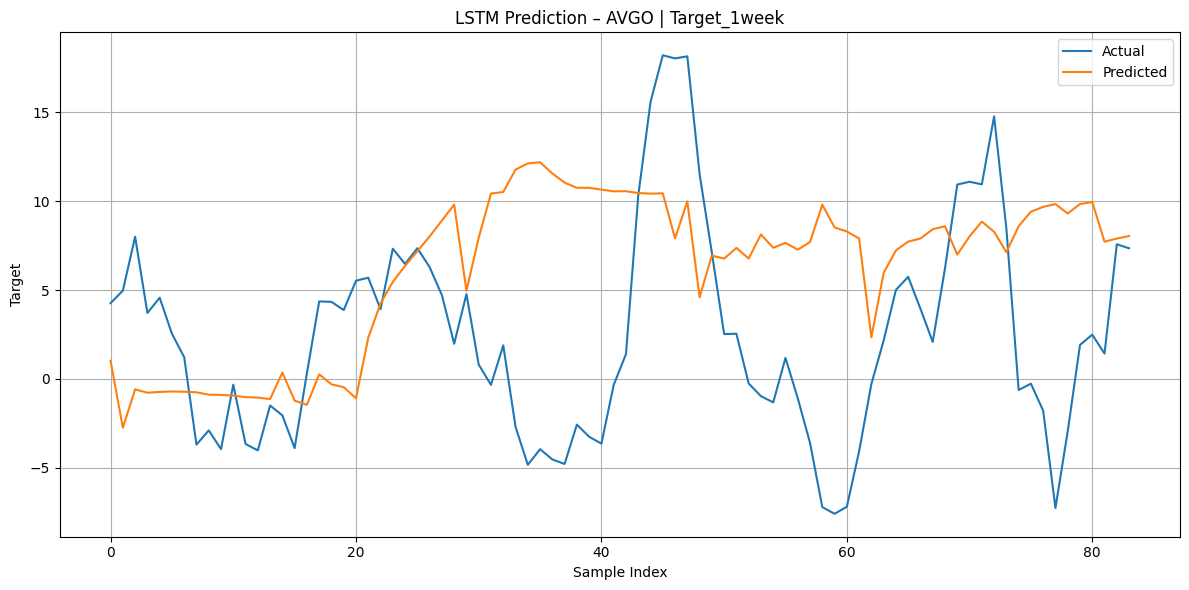

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step

 [AVGO] Target: Target_1month
MAE : 7.3612
RMSE: 8.9539
R²   : -1.4917


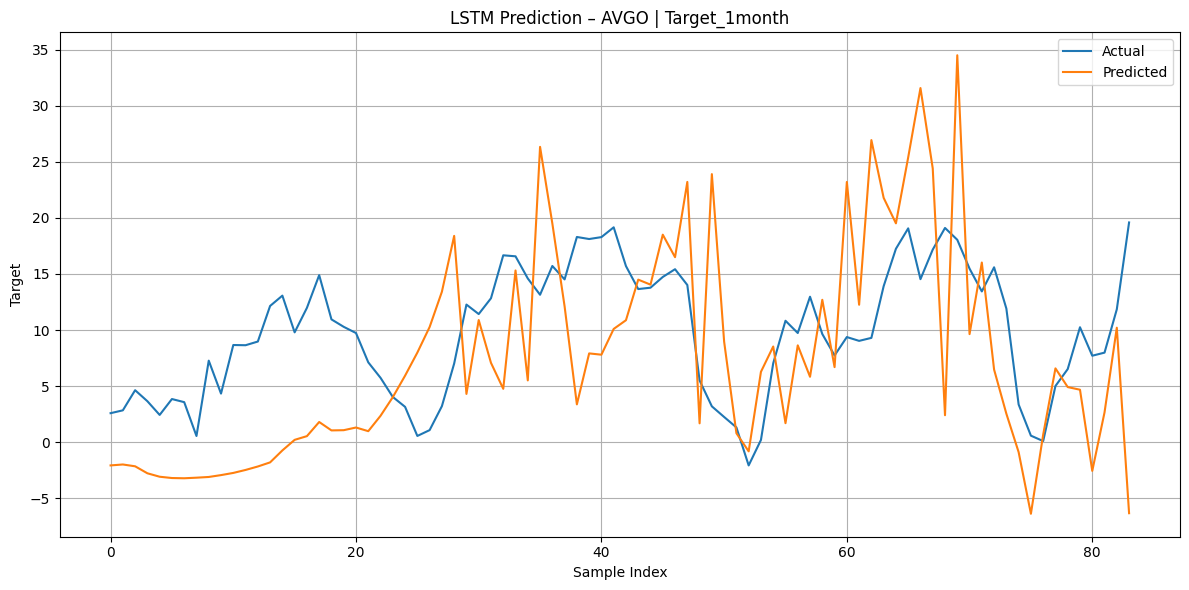

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step

 [AVGO] Target: Target_1year
MAE : 48.5748
RMSE: 58.3083
R²   : -7.6582


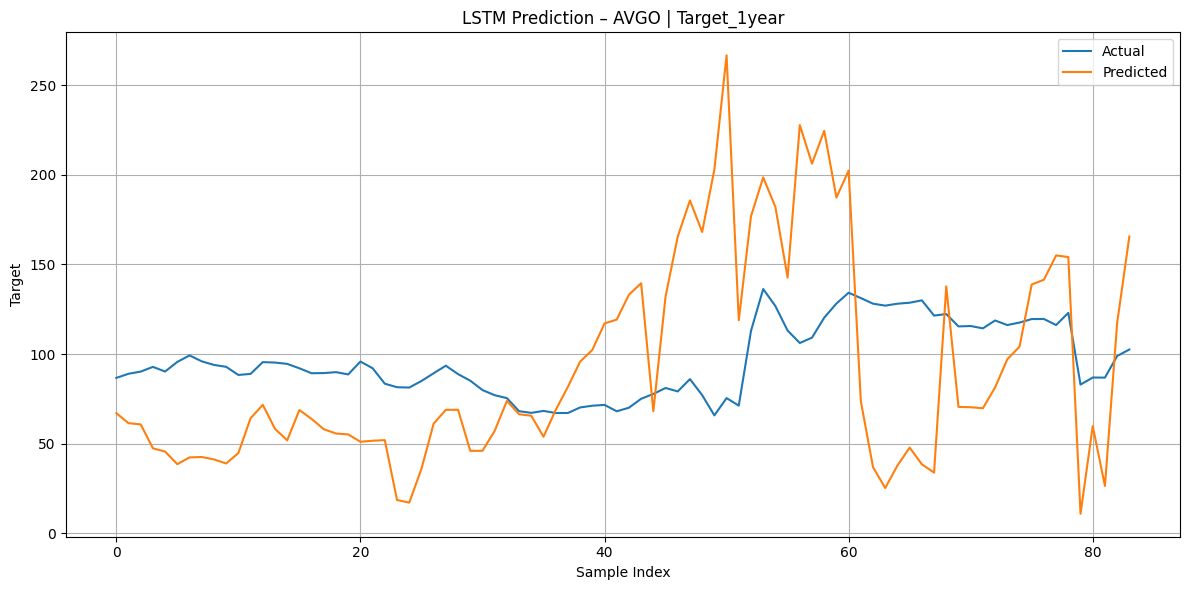

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step

 [GOOGL] Target: Target_1day
MAE : 5.0169
RMSE: 9.2964
R²   : -11.2532


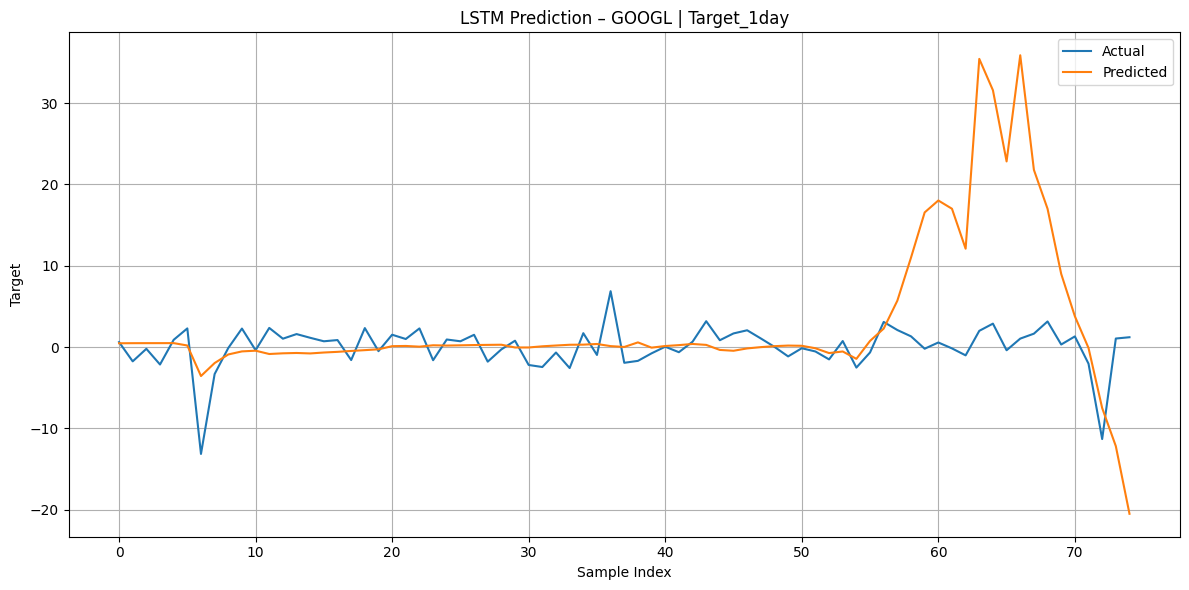

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step

 [GOOGL] Target: Target_1week
MAE : 9.1849
RMSE: 15.4528
R²   : -5.6724


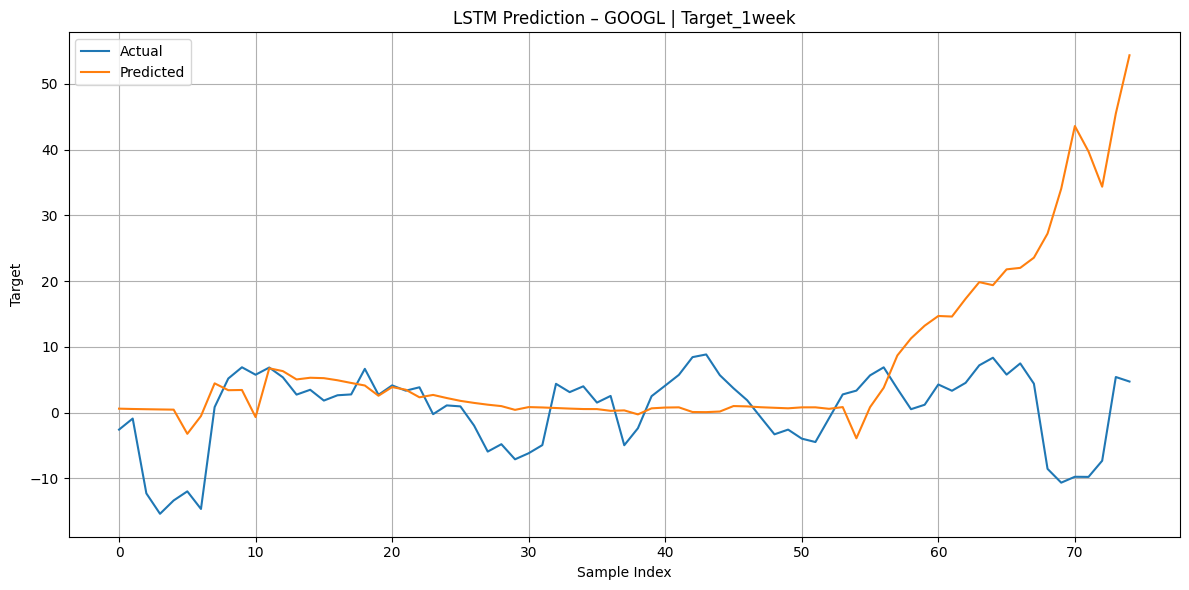

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step

 [GOOGL] Target: Target_1month
MAE : 10.3318
RMSE: 13.8389
R²   : -3.5232


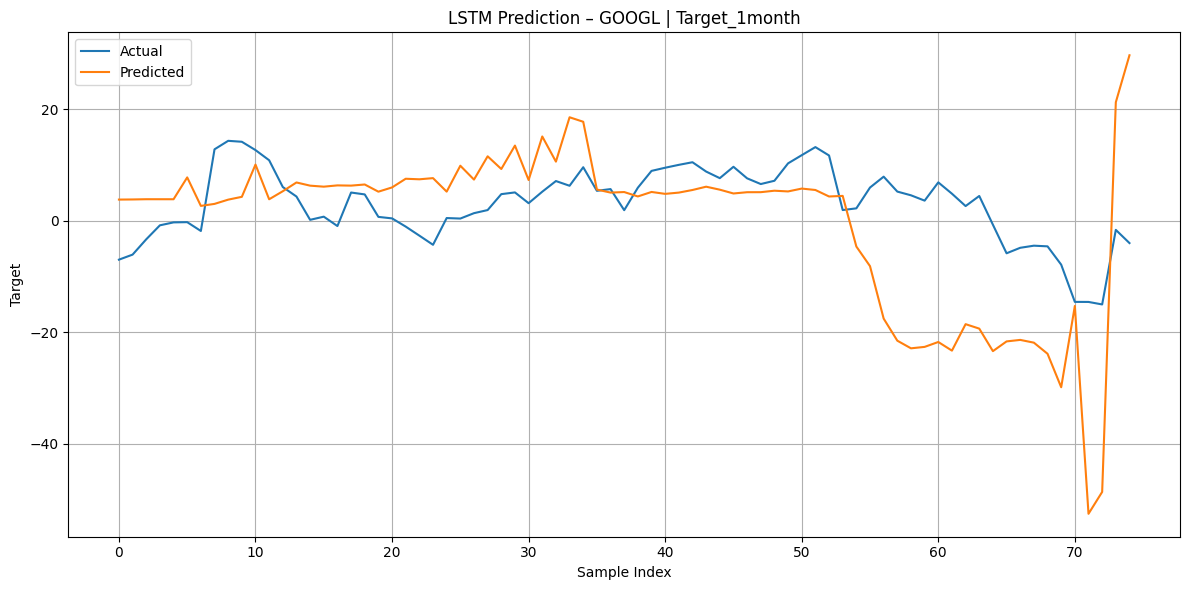

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step

 [GOOGL] Target: Target_1year
MAE : 31.5700
RMSE: 37.0869
R²   : -13.5203


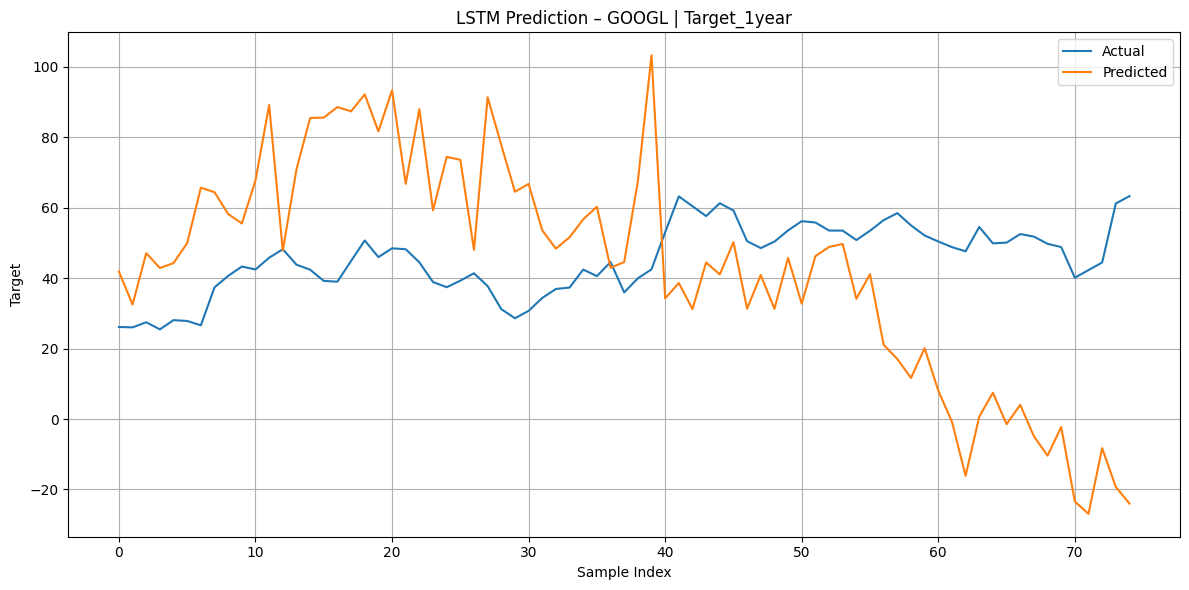

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step

 [META] Target: Target_1day
MAE : 5.2884
RMSE: 10.5640
R²   : -0.0208


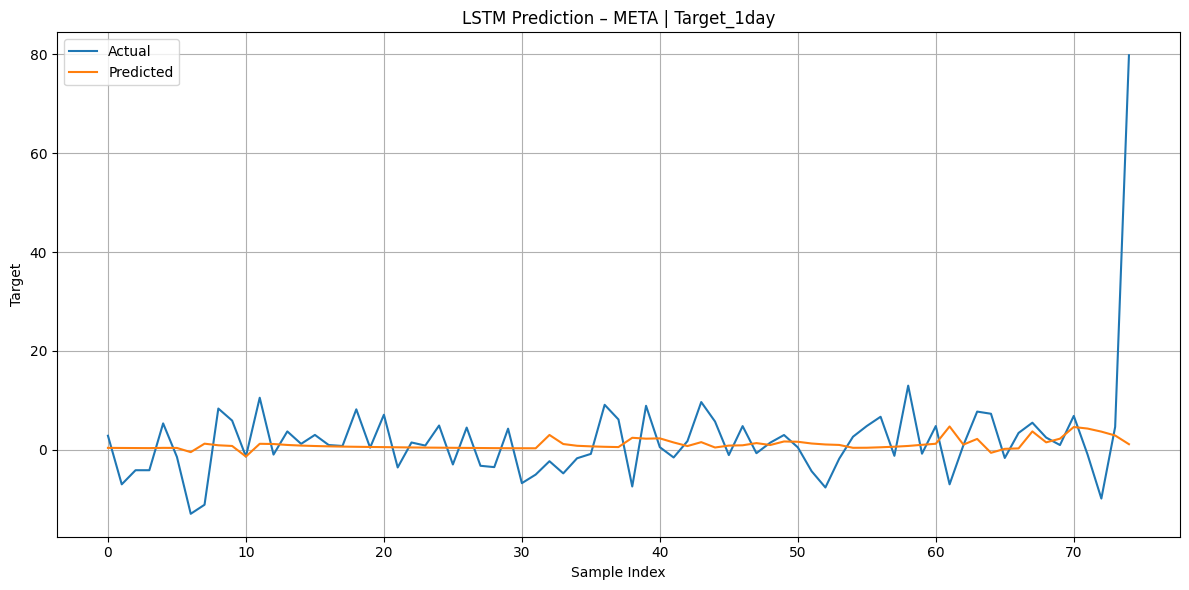

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step

 [META] Target: Target_1week
MAE : 15.8521
RMSE: 21.9336
R²   : -0.2079


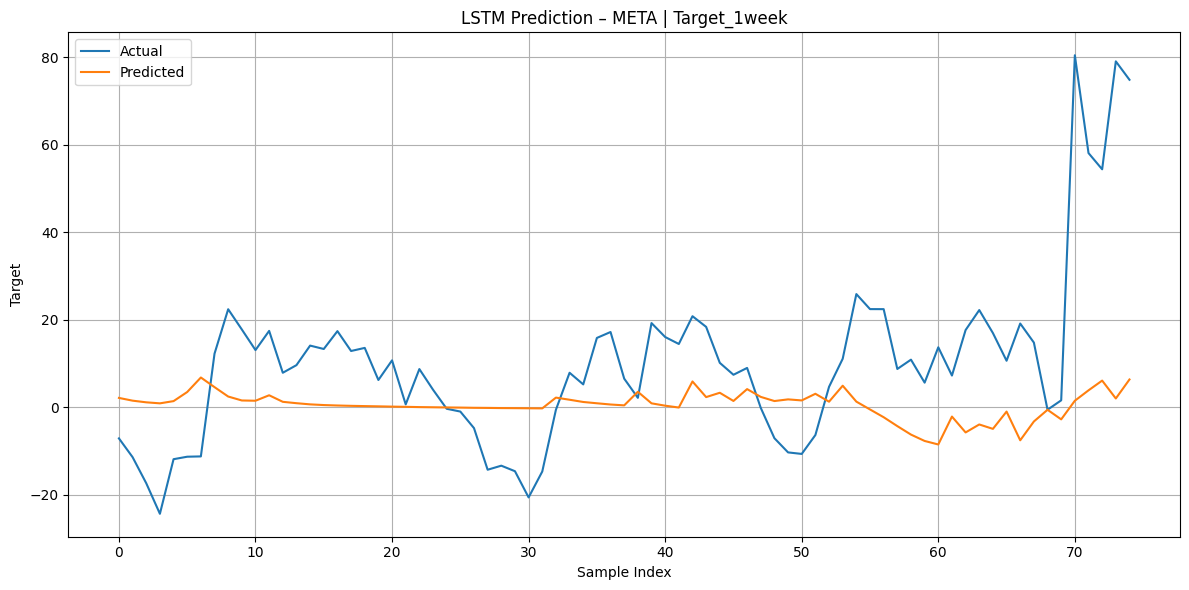

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step

 [META] Target: Target_1month
MAE : 34.1512
RMSE: 45.9605
R²   : -0.6972


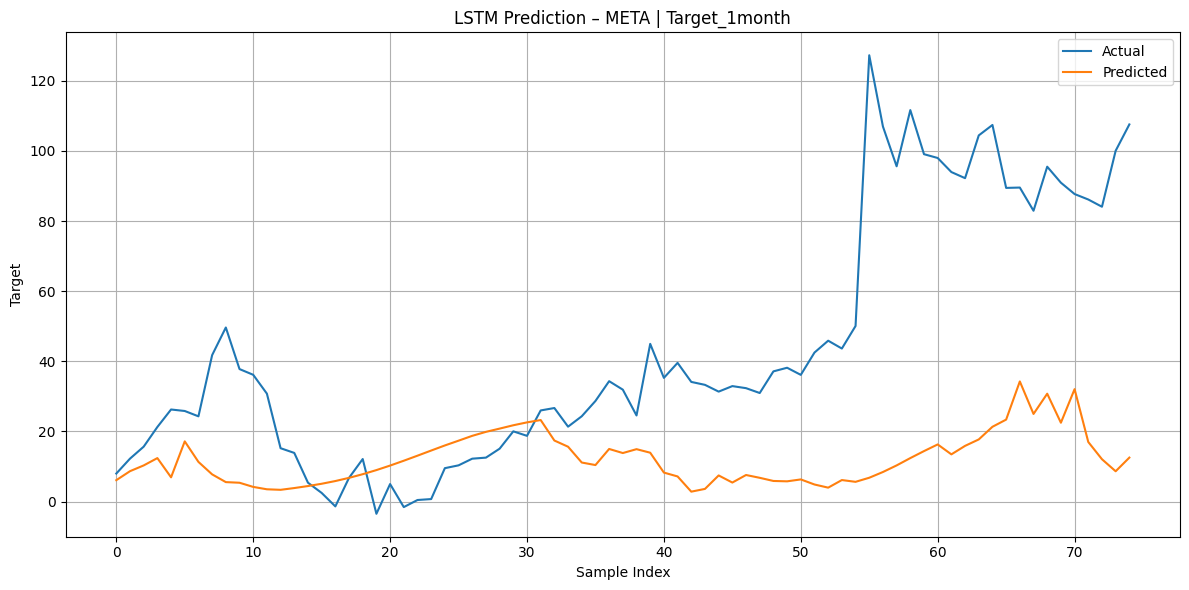

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 449ms/step

 [META] Target: Target_1year
MAE : 51.6279
RMSE: 64.5004
R²   : -8.0267


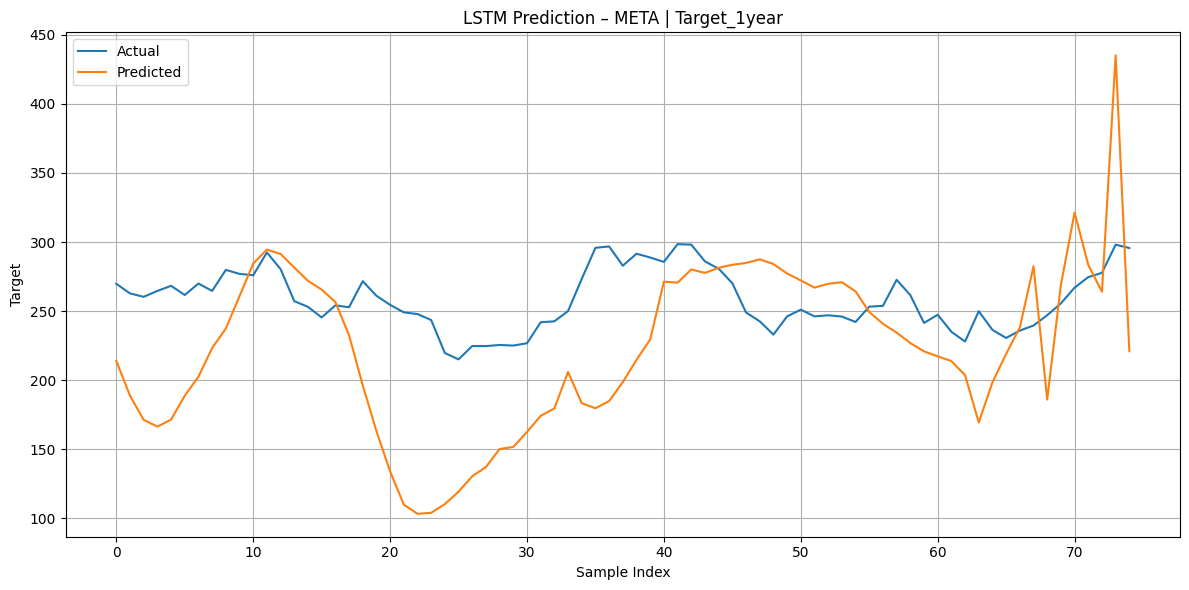

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step

 [MSFT] Target: Target_1day
MAE : 3.4934
RMSE: 4.4124
R²   : -0.0190


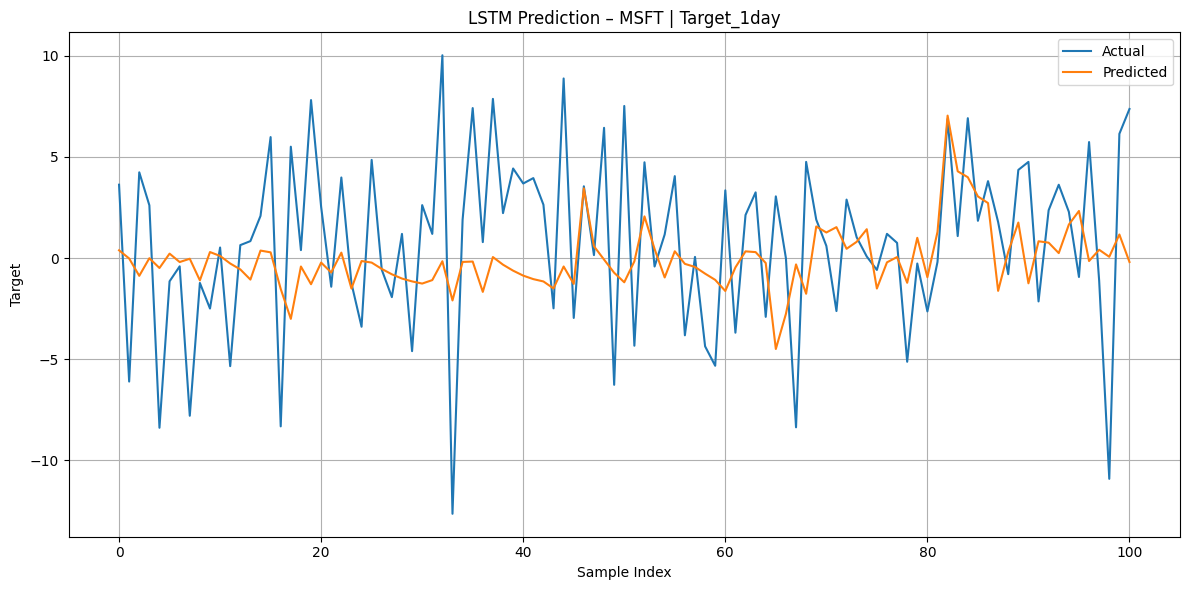

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step

 [MSFT] Target: Target_1week
MAE : 7.5896
RMSE: 9.4027
R²   : -0.1267


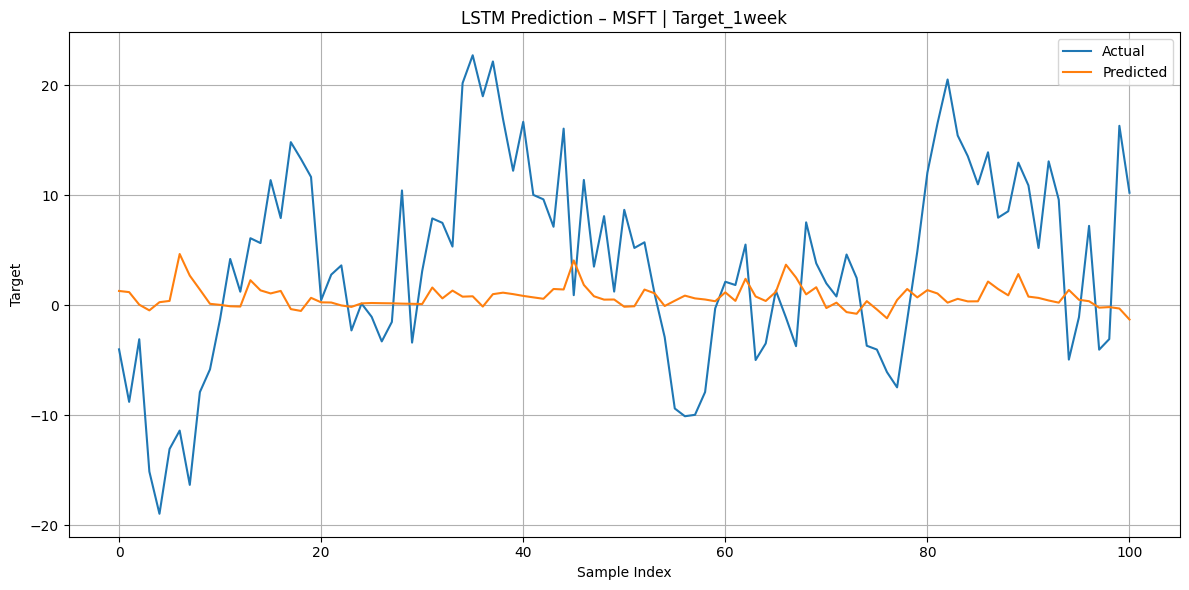

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

 [MSFT] Target: Target_1month
MAE : 19.3927
RMSE: 24.2300
R²   : -1.2380


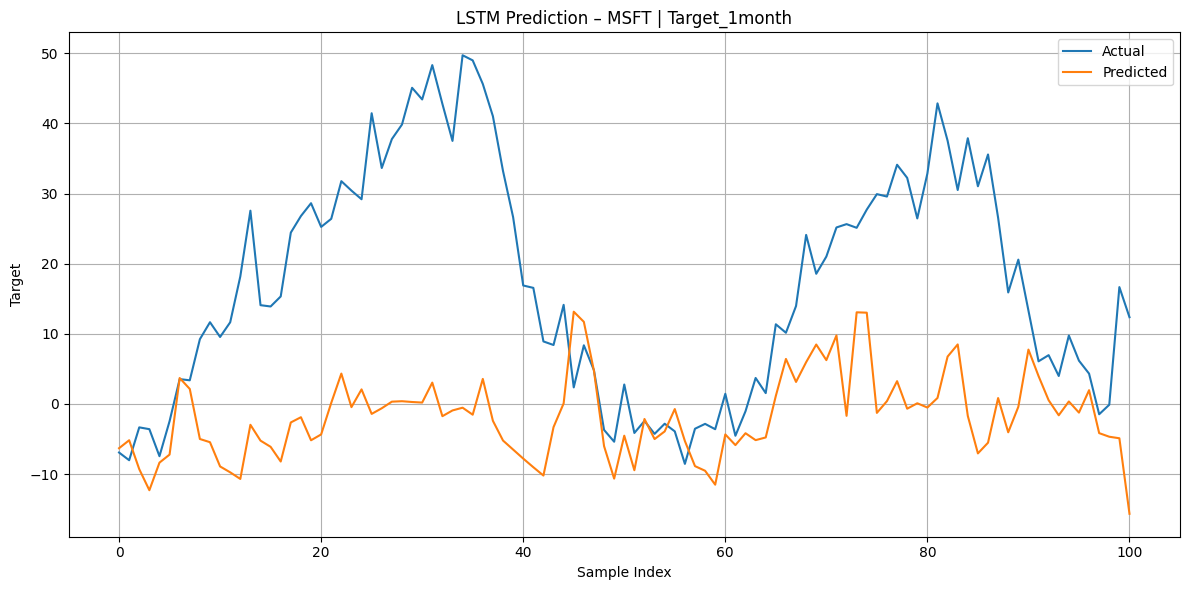

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

 [MSFT] Target: Target_1year
MAE : 24.2253
RMSE: 30.4431
R²   : -0.3610


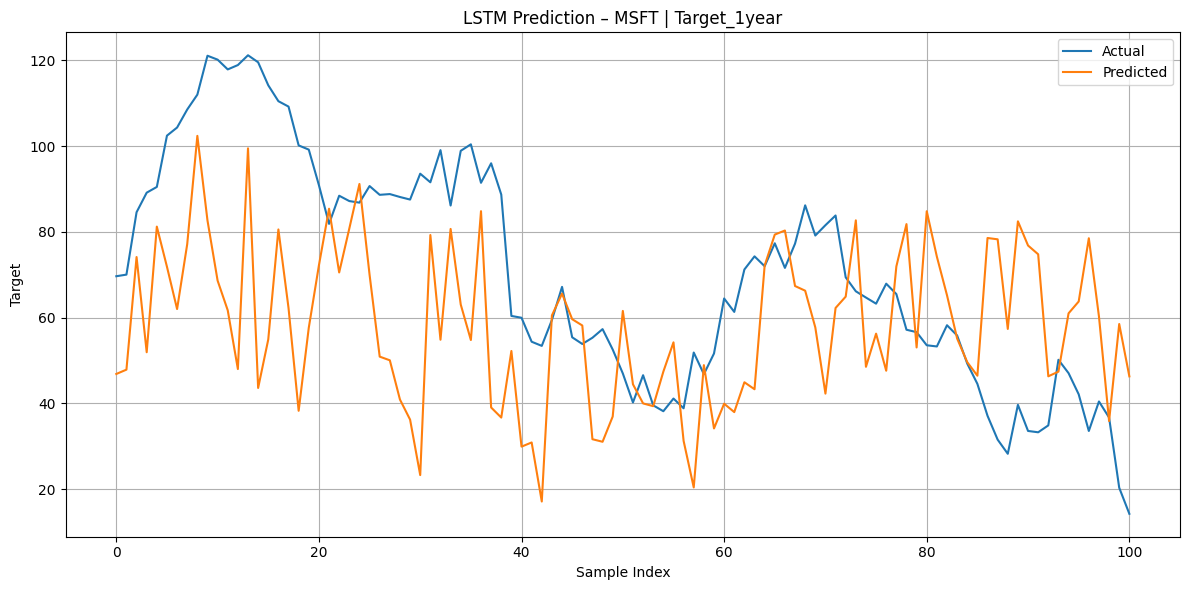

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step

 [NVDA] Target: Target_1day
MAE : 0.8730
RMSE: 1.3079
R²   : -0.6131


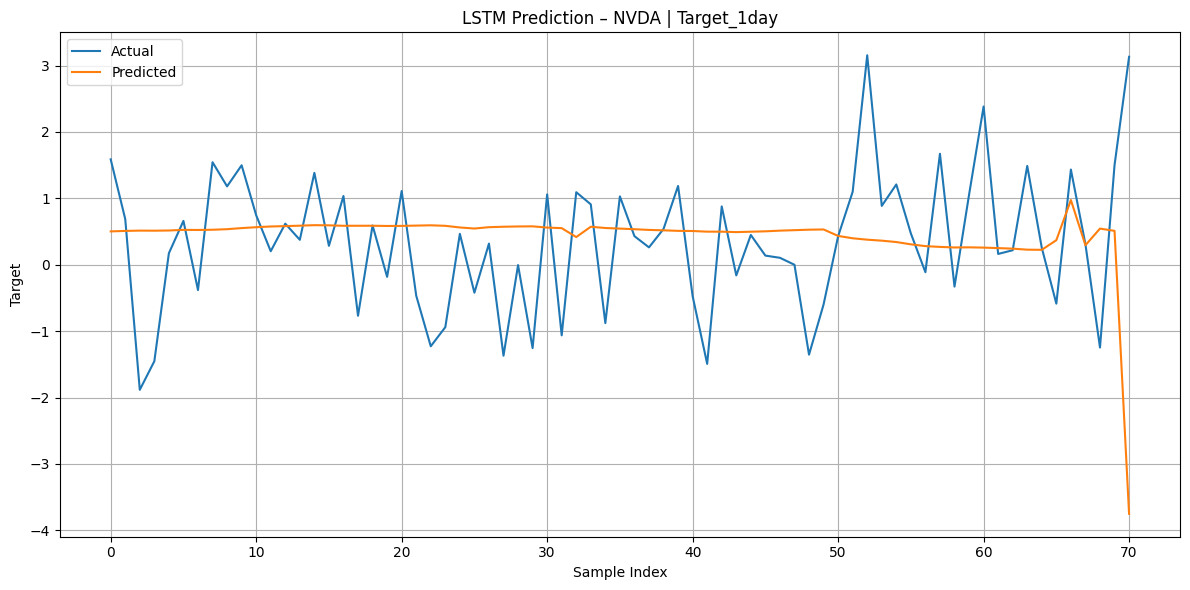

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step

 [NVDA] Target: Target_1week
MAE : 2.3779
RMSE: 2.8874
R²   : -0.1159


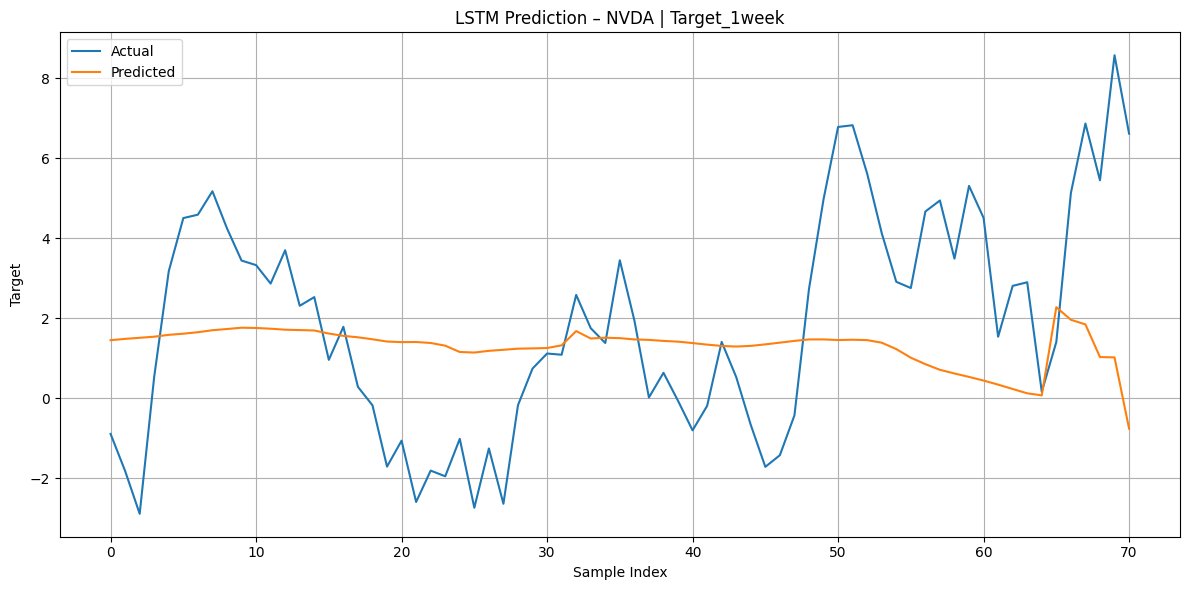

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step

 [NVDA] Target: Target_1month
MAE : 7.0068
RMSE: 8.8512
R²   : -0.8009


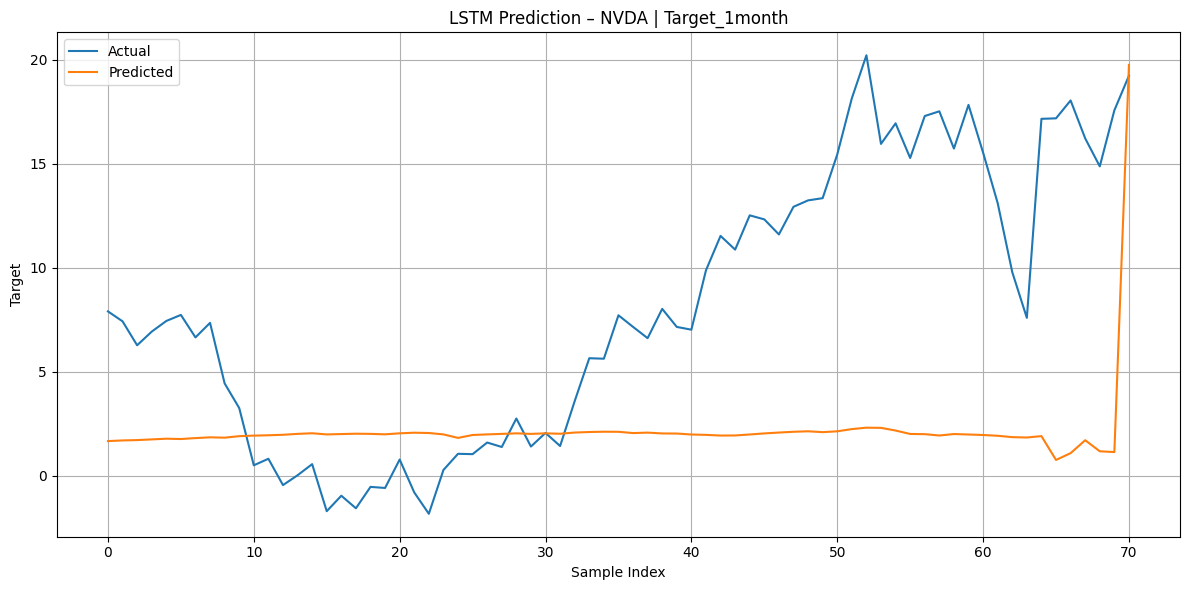

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step

 [NVDA] Target: Target_1year
MAE : 8.8836
RMSE: 17.0661
R²   : -1.7771


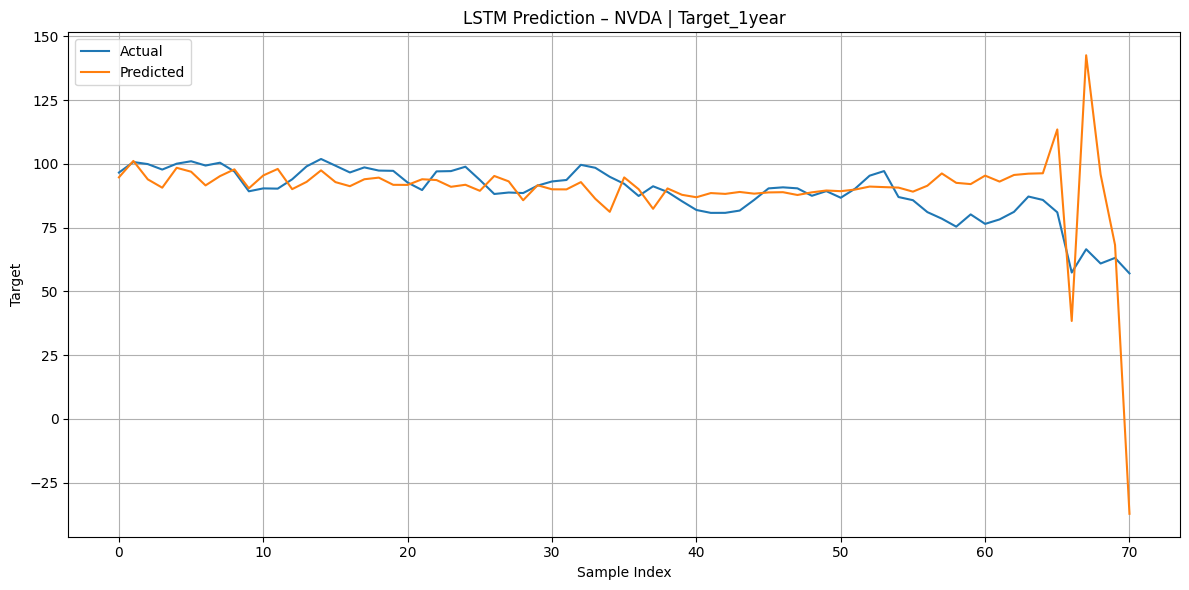

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step

 [ORCL] Target: Target_1day
MAE : 1.8242
RMSE: 2.7471
R²   : -0.0859


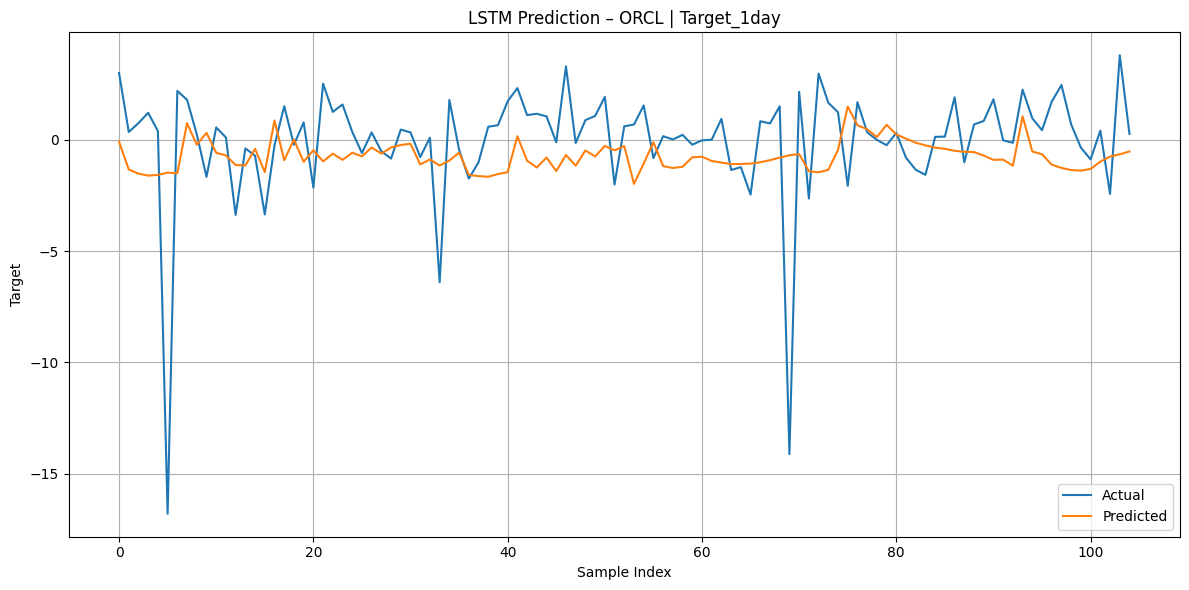

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step

 [ORCL] Target: Target_1week
MAE : 4.1576
RMSE: 5.7439
R²   : -0.2217


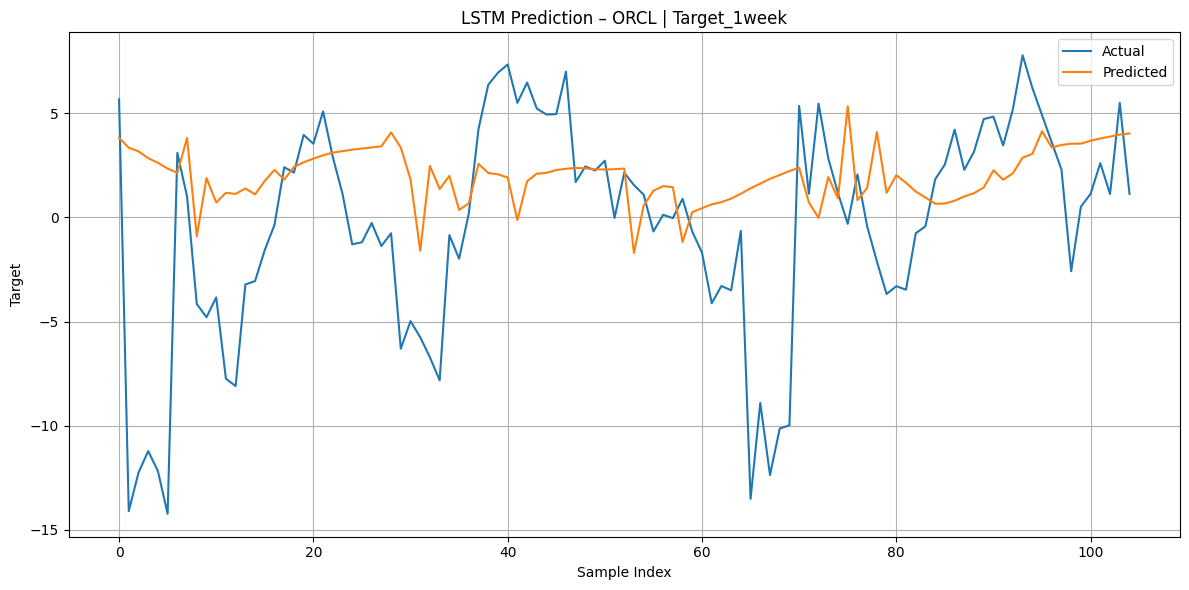

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step

 [ORCL] Target: Target_1month
MAE : 6.8459
RMSE: 8.0795
R²   : 0.1900


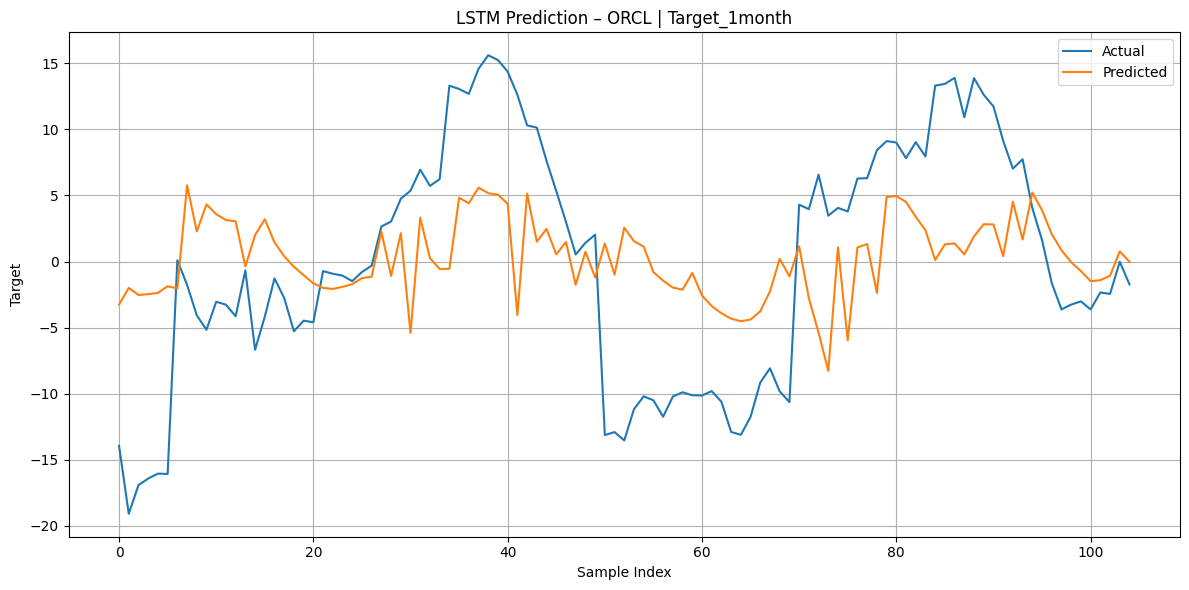

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step

 [ORCL] Target: Target_1year
MAE : 25.7540
RMSE: 26.9586
R²   : -2.8499


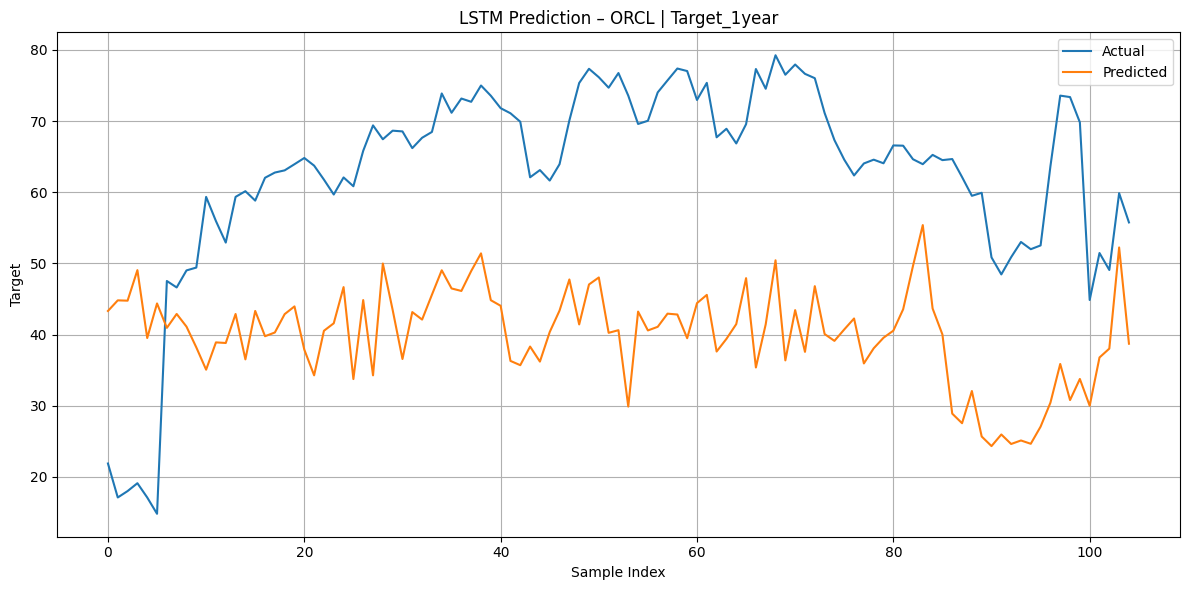

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step

 [TSLA] Target: Target_1day
MAE : 4.8584
RMSE: 6.8353
R²   : -0.0371


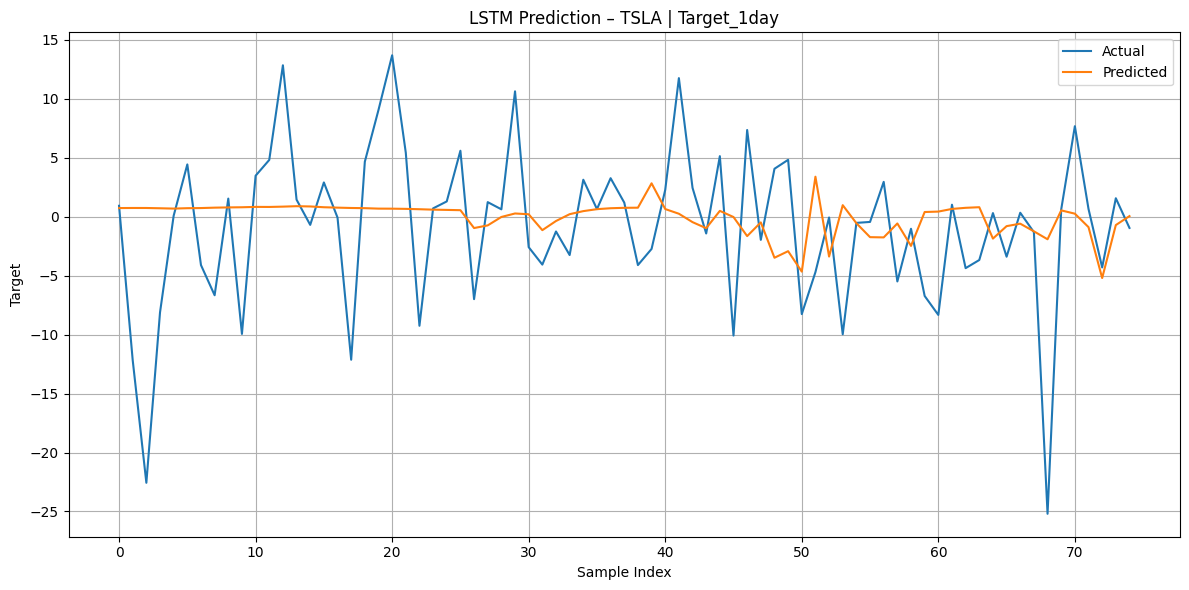

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step

 [TSLA] Target: Target_1week
MAE : 10.5545
RMSE: 13.3694
R²   : 0.1264


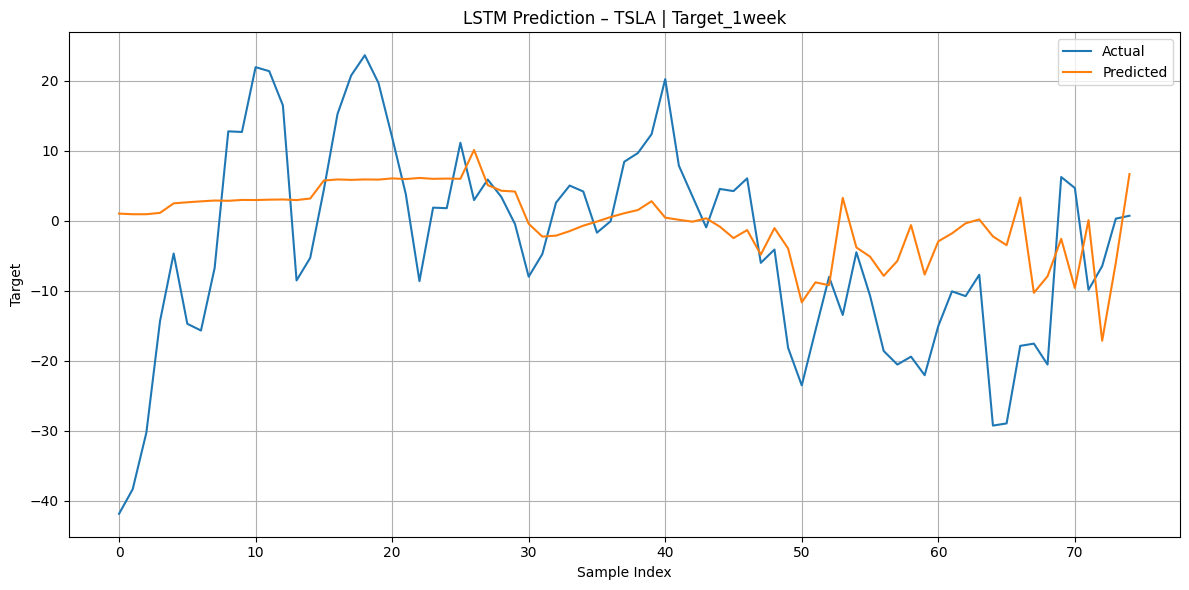

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step

 [TSLA] Target: Target_1month
MAE : 20.5355
RMSE: 27.6967
R²   : 0.1773


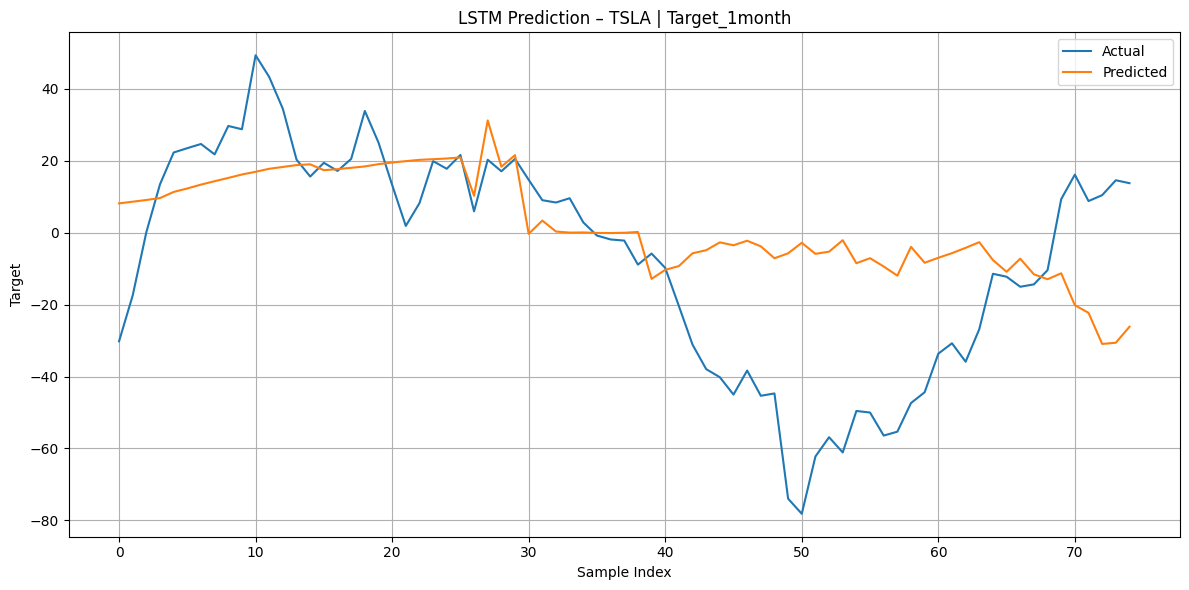

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step

 [TSLA] Target: Target_1year
MAE : 143.0232
RMSE: 155.4122
R²   : -3.7060


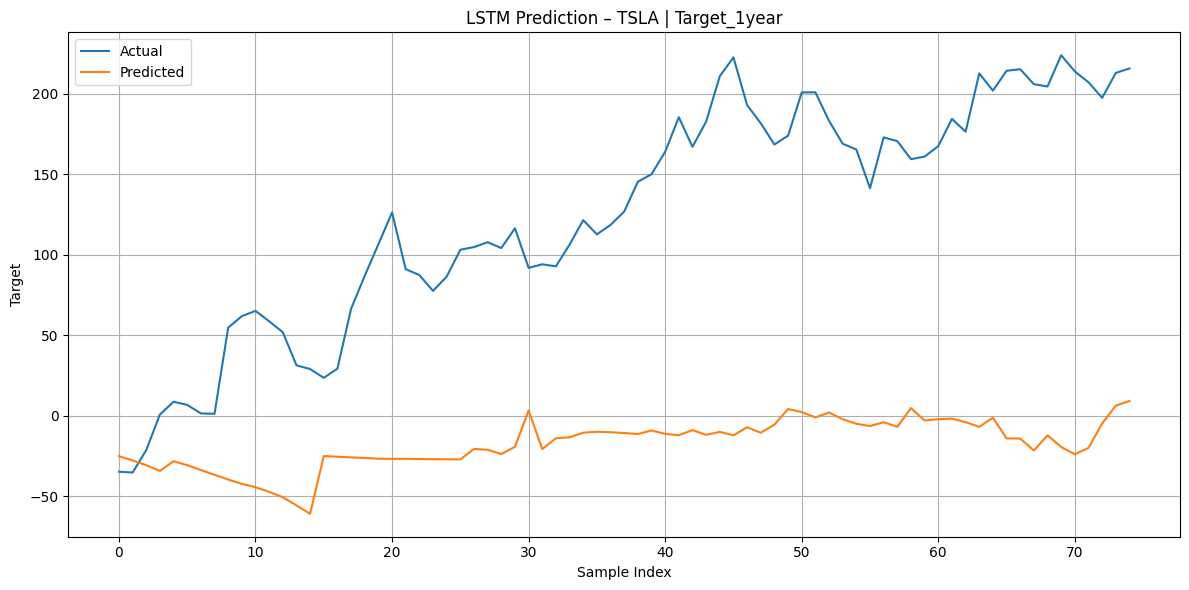

In [25]:
tickers_to_run = df['Ticker'].unique()
targets = ['Target_1day', 'Target_1week', 'Target_1month', 'Target_1year']

for ticker in tickers_to_run:
    for target in targets:
        run_lstm_by_ticker(df, ticker, target)


In [26]:
# 예시: AAPL 종목의 Close와 Target_1day 비교
sample = df[df['Ticker'] == 'AAPL'][['Date', 'Close', 'Target_1day']].reset_index(drop=True)
sample['Close_t+1'] = sample['Close'].shift(-1)
sample['Expected_Target'] = sample['Close_t+1'] - sample['Close']

print(sample[['Date', 'Close', 'Close_t+1', 'Target_1day', 'Expected_Target']].head(10))


        Date       Close   Close_t+1  Target_1day  Expected_Target
0 2021-09-30  138.863907  139.992477     1.128571         1.128571
1 2021-10-01  139.992477  136.547852    -3.444626        -3.444626
2 2021-10-04  136.547852  138.481186     1.933334         1.933334
3 2021-10-05  138.481186  139.354584     0.873398         0.873398
4 2021-10-06  139.354584  140.620560     1.265976         1.265976
5 2021-10-07  140.620560  140.237808    -0.382751        -0.382751
6 2021-10-08  140.237808  140.149490    -0.088318        -0.088318
7 2021-10-11  140.149490  138.873718    -1.275772        -1.275772
8 2021-10-12  138.873718  138.284897    -0.588821        -0.588821
9 2021-10-13  138.284897  141.081818     2.796921         2.796921


other test

In [5]:
#Read Data
# df = pd.read_csv('/Users/wonminkim/Projects/DATCapstone/data2/data.csv', index_col=0)
# Correct path for ZIP file
zip_path = '/content/DATCapstone/data/_data.csv.zip'

# Extract specific file from ZIP
with ZipFile(zip_path, 'r') as z:
    with z.open('data.csv') as f:  # Explicitly specify the file to extract
        df = pd.read_csv(f, index_col=0)


df['Date'] = pd.to_datetime(df['Date'])

#Forward fill -> micro, macro, stock / fill na -> sentiment
df[df.columns[1:40]] = df.groupby('Ticker')[df.columns[1:40]].ffill()
df[df.columns[40:-5]] = df[df.columns[40:-5]].fillna(0)

df = df.dropna(subset=df.columns[0:-5])

# Sorting
df = df.sort_values(by=['Ticker', 'Date']).reset_index(drop=True)

# Lag feature (Exclude embedding columns)
lag_cols = df.columns[1:44]
lags = [1, 3, 5, 7, 14, 30]
lag_features = []

for col in lag_cols:
    for lag in lags:
        lagged = df.groupby('Ticker')[col].shift(lag)
        lag_features.append(lagged.rename(f'{col}_lag{lag}'))

lag_df = pd.concat(lag_features, axis=1)

df = pd.concat([df.reset_index(drop=True), lag_df.reset_index(drop=True)], axis=1)

In [6]:
import glob
import os

# Read articles df
csv_files = glob.glob(os.path.join(os.getcwd(), "*articles*.csv"))

df_articles_list = []

for file in csv_files:
    # get ticker from filename
    ticker = os.path.basename(file).split('_')[0]
    df_articles = pd.read_csv(file)
    df_articles['Ticker'] = ticker
    df_articles_list.append(df_articles)

# concat articles dataframe
df_articles = pd.concat(df_articles_list, ignore_index=True)

# Articles dataframe preprocessing
df_articles["Date"] = pd.to_datetime(df_articles["time"], errors='coerce', utc=True).dt.tz_convert(None).dt.date
df_articles = df_articles[['Date', 'Ticker', 'sentiment']]
sentiment_dummies = pd.get_dummies(df_articles['sentiment'])
df_encoded = pd.concat([df_articles[['Date', 'Ticker']], sentiment_dummies], axis=1)
df_articles = df_encoded.groupby(['Date', 'Ticker']).sum().reset_index()
df_articles['Date'] = pd.to_datetime(df_articles['Date'])

df_articles['articles_avg_sentiment'] = (df_articles['Negative'] * -1 + df_articles['Neutral'] * 0 + df_articles['Positive']) / (df_articles['Negative'] + df_articles['Neutral'] + df_articles['Positive'])
df_articles.columns = ['Date', 'Ticker', 'Articles_Negative', 'Articles_Neutral', 'Articles_positive', 'Articles_avg_sentiment']
df_articles

df = pd.merge(df, df_articles, on=['Date', 'Ticker'], how = 'left')

# Fill 0 except the target columns
df[[col for col in df.columns if 'Target' not in col]] = df[[col for col in df.columns if 'Target' not in col]].fillna(0)

In [10]:
print(df.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'GDP (Billions USD)', 'Unemployment Rate (%)',
       ...
       'positive_lag1', 'positive_lag3', 'positive_lag5', 'positive_lag7',
       'positive_lag14', 'positive_lag30', 'Articles_Negative',
       'Articles_Neutral', 'Articles_positive', 'Articles_avg_sentiment'],
      dtype='object', length=1079)


LSTM

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [12]:
# 여기부터 원래 코드
df = df.sort_values(by=["Ticker", "Date"]).reset_index(drop=True)
df["time_idx"] = df.groupby("Ticker").cumcount()


feature_cols = [col for col in df.columns if 'Target' not in col and col not in ['Date', 'Ticker', 'time_idx']]

target_col = "Target_1day"


In [ ]:
df_single = df[df['Ticker'] == selected_ticker].copy()
df_single = df_single.dropna(subset=[target_col])

X = df_single[feature_cols].values
y = df_single[target_col].values

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
def create_sequences(X, y, look_back=30):
    Xs, ys = [], []
    for i in range(look_back, len(X)):
        Xs.append(X[i-look_back:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test)

In [17]:
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=20,
    batch_size=16,
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)

Epoch 1/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - loss: 103.3078 - val_loss: 46.7315
Epoch 2/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - loss: 57.8073 - val_loss: 217.0938
Epoch 3/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - loss: 55.6002 - val_loss: 33.8217
Epoch 4/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - loss: 25.5041 - val_loss: 29.4563
Epoch 5/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - loss: 27.6942 - val_loss: 58.5801
Epoch 6/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 23.5310 - val_loss: 23.4129
Epoch 7/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 18.7729 - val_loss: 18.0736
Epoch 8/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 32.0731 - val_loss: 23.4202
Epoch 9/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 15.7844 - val_loss: 14.9752
Epoch 10/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - loss: 14.8927 - val_loss: 23.6258
Epoch 11/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - loss: 22.7221 - val_loss: 17.2449
Epoch 

In [19]:
y_pred = model.predict(X_test_seq).flatten()

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [20]:
y_pred = model.predict(X_test_seq).flatten()

mae = mean_absolute_error(y_test_seq, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
r2 = r2_score(y_test_seq, y_pred)

print(f"LSTM Results for - Target_1day")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
LSTM Results for - Target_1day
MAE: 33.70
RMSE: 46.26
R²  : -161.6233


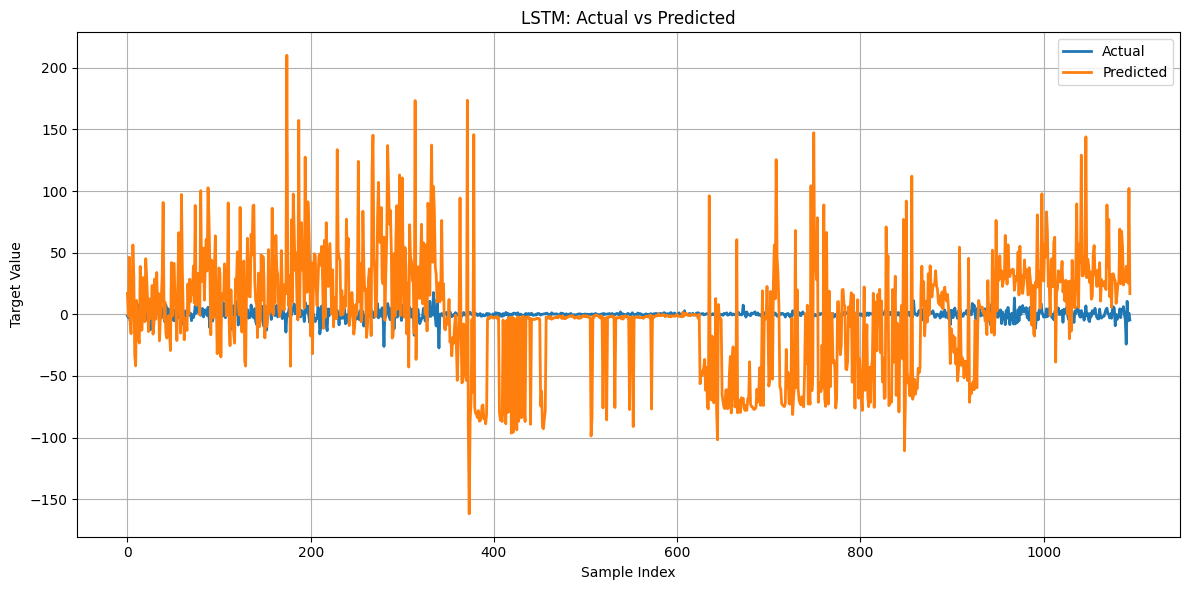

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linewidth=2)
plt.title(f'LSTM: Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


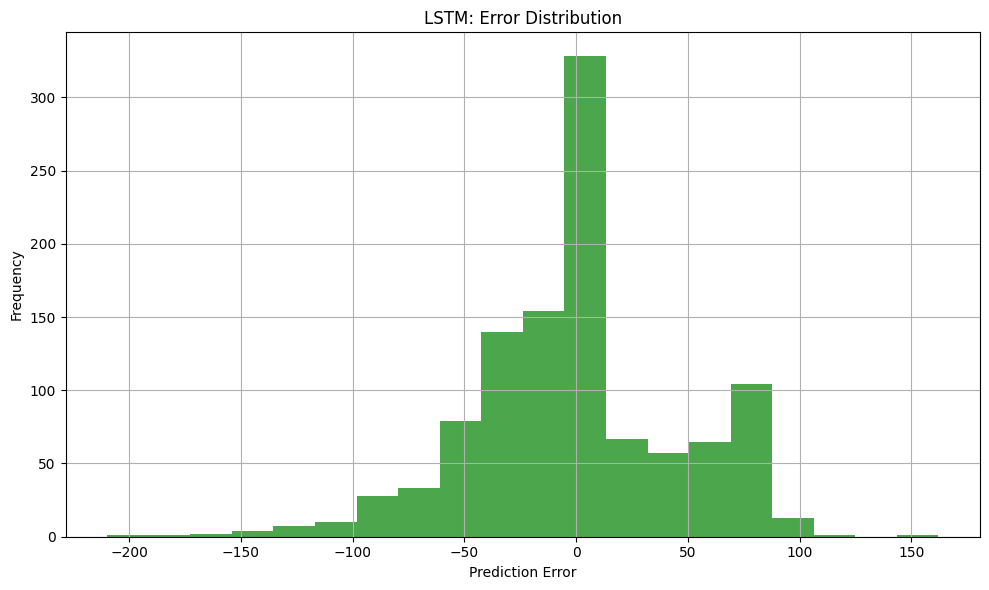

In [22]:
errors = y_test_seq - y_pred
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=20, color='green', alpha=0.7)
plt.title("LSTM: Error Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


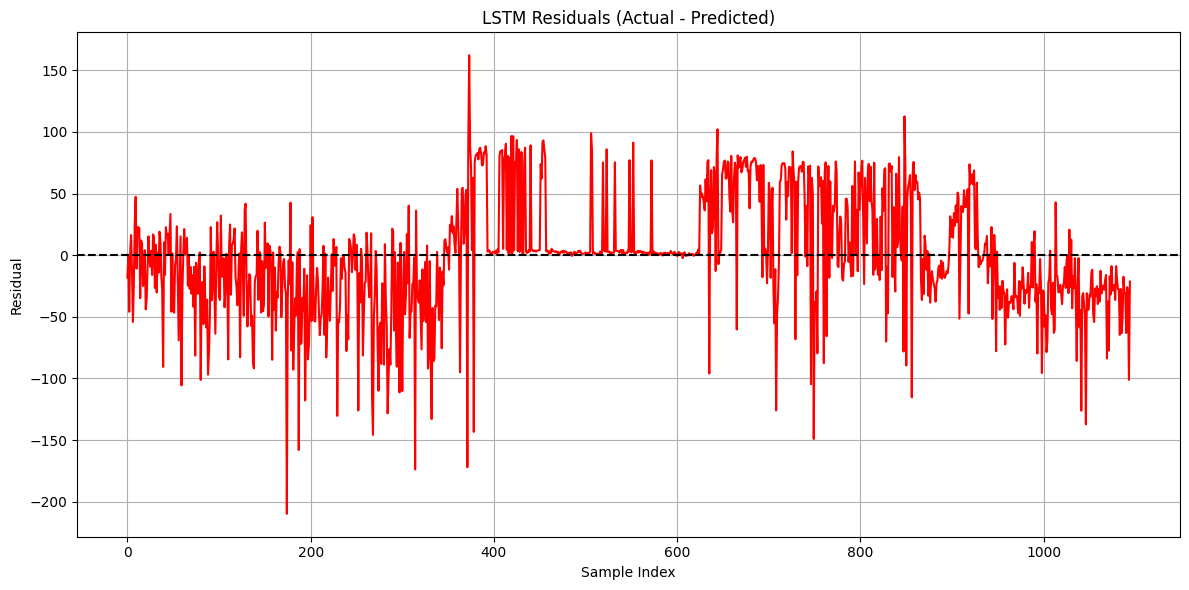

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(errors, color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title('LSTM Residuals (Actual - Predicted)')
plt.xlabel('Sample Index')
plt.ylabel('Residual')
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
look_back = 30

for target_col in ['Target_1day', 'Target_1week', 'Target_1month', 'Target_1year']:
    print(f"\nTraining LSTM for {target_col}...\n")

    df_single = df[df['Ticker'] == selected_ticker].copy()
    df_single = df_single.dropna(subset=[target_col])

    # Feature scaling
    X = df_single[feature_cols].values
    y = df_single[target_col].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_seq_train, y_seq_train = create_sequences(X_train_scaled, y_train, look_back)
    X_seq_test, y_seq_test = create_sequences(X_test_scaled, y_test, look_back)

    model = Sequential([
        LSTM(64, activation='relu', input_shape=(X_seq_train.shape[1], X_seq_train.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(
        X_seq_train, y_seq_train,
        epochs=20,
        batch_size=16,
        validation_data=(X_seq_test, y_seq_test),
        verbose=0
    )

    y_pred = model.predict(X_seq_test).flatten()

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(y_seq_test, label='Actual', color='blue', linewidth=2)
    plt.plot(y_pred, label='Predicted', color='orange', linestyle='--', linewidth=2)
    plt.title(f"LSTM: Actual vs Predicted – {target_col}")
    plt.xlabel("Sample Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    mae = mean_absolute_error(y_seq_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_seq_test, y_pred))

    print(f"{target_col} – MAE: {mae:.2f}, RMSE: {rmse:.2f}")



Training LSTM for Target_1day...



NameError: name 'selected_ticker' is not defined

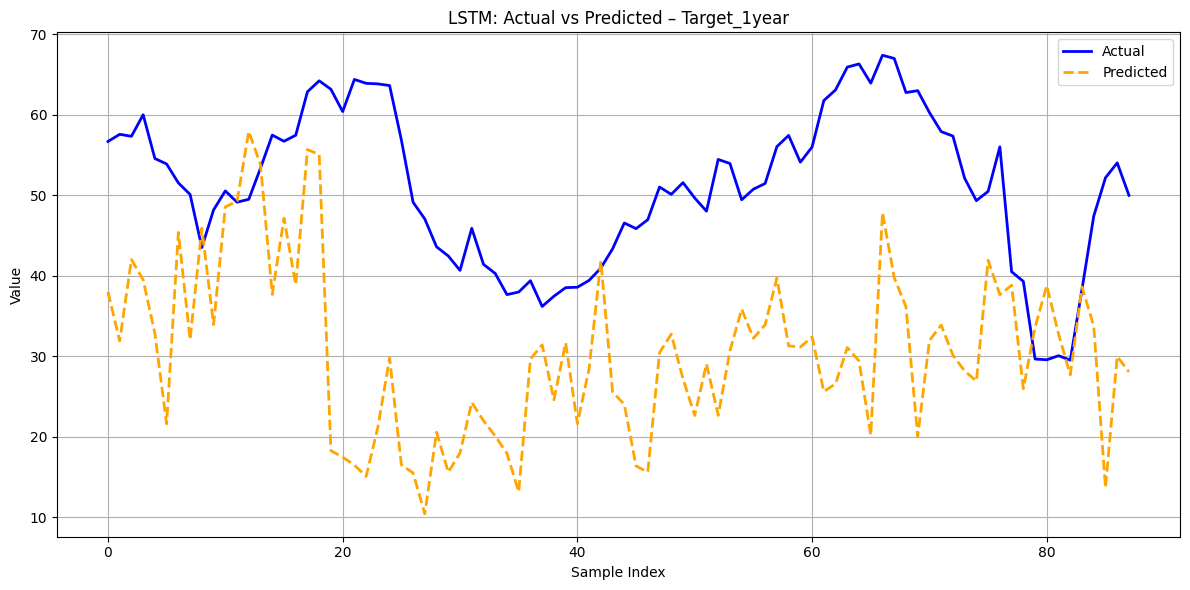

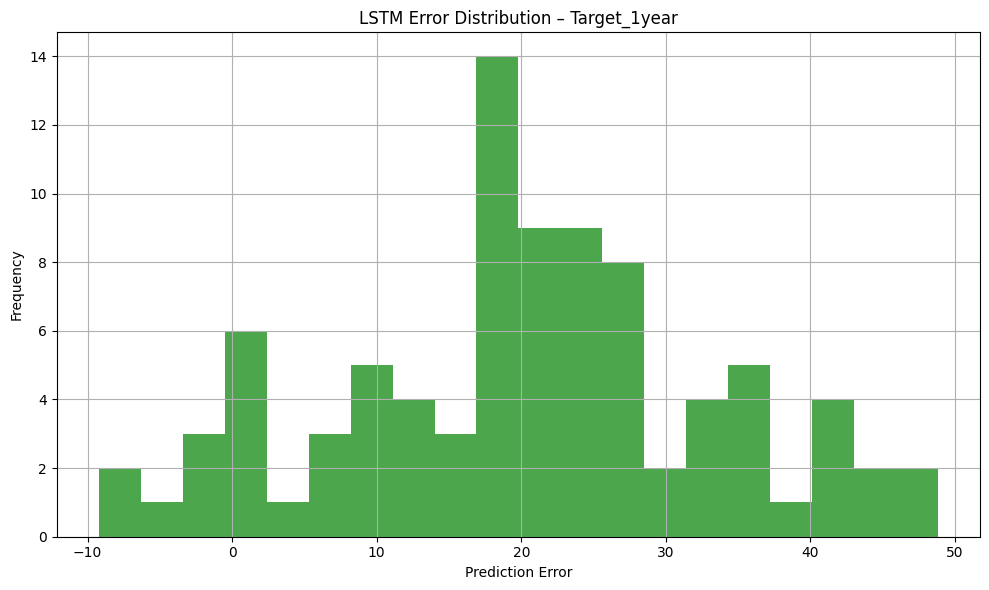

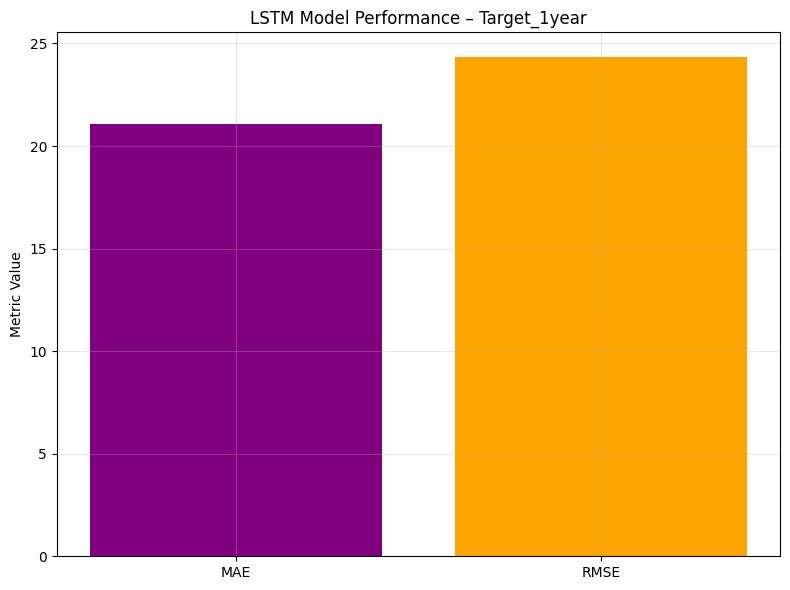

In [116]:
    # Visualization: Actual vs Predicted
    plt.figure(figsize=(12, 6))
    plt.plot(y_seq_test, label='Actual', color='blue', linewidth=2)
    plt.plot(y_pred, label='Predicted', color='orange', linestyle='--', linewidth=2)
    plt.title(f"LSTM: Actual vs Predicted – {target_col}")
    plt.xlabel("Sample Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Error Distribution
    errors = y_seq_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=20, color="green", alpha=0.7)
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.title(f"LSTM Error Distribution – {target_col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Metrics Bar Chart
    metrics = {"MAE": mae, "RMSE": rmse}
    plt.figure(figsize=(8, 6))
    plt.bar(metrics.keys(), metrics.values(), color=["purple", "orange"])
    plt.ylabel("Metric Value")
    plt.title(f"LSTM Model Performance – {target_col}")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
